強化学習のA2Cを用いた学習を行いたい。シナリオは以下の通り。

V2X上に3つのブロックチェーンを用意する。一つのRSUに対して一つのブロックチェーンが対応する。この時道路を走行中の車両をどれかに所属させたい。この時三つのブロックチェーンの所属車両数はある程度均等になるようにするとともに、RSUに近い車両、RSUに近づいてくる車両は優先的にそのRSUに所属するようにしたい。どのようなA2Cになりますか？今のところデータとしてはRSUの位置、車両の位置、車両の速度は持っている。また車両データを一度に渡し、それを元に配属を決める形にしたい。またRSUに事前に割り当てられている車両はなく、毎回車両群データが渡されてから割り当て車両を全て決定する。

位置データの作成

In [57]:
import json


def make_immu_training_data(log_folder_path):
	extracted_events_file_path = log_folder_path + "extracted_events.json"
	
	with open(extracted_events_file_path, 'r') as f:
		extracted_data = json.load(f)

	# 必要な情報を抽出して辞書にまとめる
	receivable_time_id_data = {}
	for key, value in extracted_data.items():
		geographic_dict = {}
		for vehicle_key, vehicle_value in value["receiver_results"].items():
			if vehicle_value["reception_status"] == "possible":
				geographic_dict[vehicle_key] = vehicle_value["position"]
		
		receivable_time_id_data[value["startTime"]] = geographic_dict



	round_time_id_data = {}
	for key, value in receivable_time_id_data.items():
		round_time_id_data[str(f"{round(float(key), 2):.2f}")] = value


	# order the keys
	round_time_id_data = dict(sorted(round_time_id_data.items(), key=lambda x: float(x[0])))


	extended_time_id_data = {}
	# 元の辞書のキーと値をループして処理
	for key, value in round_time_id_data.items():
		# 新しいキーを追加
		extended_time_id_data[key] = value

		# 小数部を1ずつ増やしながら、指定された範囲のキーが欠けている場合に追加する
		for decimal in range(1,10):
			new_key = f"{round(float(key) + decimal * 0.01, 2):.2f}"
			# 小数点第三位で四捨五入
			if new_key not in round_time_id_data:  # 新しいキーが元の辞書に存在しない場合
				extended_time_id_data[new_key] = value  # 新しいキーを追加し、空のリストを値として設定
			else:
				break

	# write to the json file
	with open( log_folder_path + 'extended_time_geographic_data.json', 'w') as f:
		json.dump(extended_time_id_data, f, indent=4)



# read the json file
max_speed = 70 # km/hour
min_speed = 30
booth_change = True
has_multi_proposer = True
proposer_list = [0,1,2]
validator_num = 160
validator_list = [i for i in range(validator_num  + len(proposer_list)) if i not in proposer_list]


for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/" + str(proposer_id) + "/"
	make_immu_training_data(log_folder_path)



車両の数変更（本番）

# 古いversion 学習時にダミーデータ入れない

envの読み込み

In [ ]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.min_space = -20
        self.max_space = 1800
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ

        # 観測空間を変更（速度情報を削除）
        # self.observation_space = spaces.Box(low=self.min_space, high=self.max_space, shape=(max_vehicles * 2,), dtype=np.float32)

        # RSU の位置情報も観測空間に含めるようにする
        self.observation_space = spaces.Box(
            low=self.min_space, 
            high=self.max_space, 
            shape=(self.max_vehicles * 2 + num_rsus * 2,), 
            dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        self.rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
        ])

    def set_initial_vehicle_positions(self, vehicle_positions):
        """
        車両の初期位置を設定する関数。観測空間内の位置に合わせて正しい形状で入力してください。
        max_vehicles以下の入力であれば、残りをダミーデータとして補完します。
        
        引数:
            vehicle_positions: 車両の位置リスト、shapeは(N, 2)で、範囲は[0, 100]（Nはmax_vehicles以下）
        """
        num_input_vehicles = vehicle_positions.shape[0]
        assert num_input_vehicles <= self.max_vehicles, "入力車両の数はmax_vehicles以下にしてください。"
        
        # ダミーデータを追加して max_vehicles に合わせる
        dummy_vehicle_positions = []
        for i in range(self.max_vehicles - num_input_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]
            dummy_vehicle_positions.append(rsu_pos)  # RSU周りに均等配置

        # 入力された車両位置とダミーデータを結合し、観測空間に合わせてクリップ
        #もしdummy_vehicle_positionsがからの場合、np.vstackでエラーが発生するので、if文で分岐
        if len(dummy_vehicle_positions) == 0:
            all_vehicle_positions = vehicle_positions
        else:
            all_vehicle_positions = np.vstack([vehicle_positions, dummy_vehicle_positions])
        self.vehicle_positions = np.clip(all_vehicle_positions, self.min_space, self.max_space)
        return self._get_observation()
    
    def set_initial_vehicle_positions_random(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []
        for i in range(num_valid_vehicles):
            # x 座標は 0 から self.max_space の範囲でランダムに設定
            x_position = np.random.uniform(0, self.max_space)
            # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
            y_position = np.random.choice([8.4, 11.6])
            # 車両の位置として追加
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()

    def reset(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = self.max_vehicles
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []

        # ランダムな分割点を作成し、各人に割り当てるリンゴを計算
        min_vehicles_per_rsu = 20
        remaining_vehicles = self.max_vehicles - (self.num_rsus * min_vehicles_per_rsu)
        allocations = [0] + sorted(random.choices(range(0, remaining_vehicles+1), k=self.num_rsus - 1)) + [remaining_vehicles]
        allocations = [allocations[i] - allocations[i - 1] for i in range(1, len(allocations))]
        allocations = [min_vehicles_per_rsu + add for add in allocations]
        allocations = [i for i, count in enumerate(allocations) for _ in range(count)]

        # 車両の位置を設定
        for allocation_item in allocations:
            if allocation_item == 0:
                x_position = np.random.uniform(100, 650)
            elif allocation_item == 1:
                x_position = np.random.uniform(650, 1150)
            elif allocation_item == 2:
                x_position = np.random.uniform(1150, 1700)
            y_position = np.random.choice([8.4, 11.6])
            vehicle_position = [x_position, y_position]
            self.vehicle_positions.append(vehicle_position)
        
        # for i in range(num_valid_vehicles):
        #     # x 座標は 0 から self.max_space の範囲でランダムに設定
        #     # x_position = np.random.uniform(0, self.max_space)
        #     # x_position = np.random.uniform(200, 1800)
        #     x_position = np.random.uniform(100, 1700)
        #     # y 座標は 8.4 または 11.6 のどちらかをランダムに選択
        #     y_position = np.random.choice([8.4, 11.6])
        #     # 車両の位置として追加
        #     vehicle_position = [x_position, y_position]
        #     self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])

        # 配列として固定サイズのshapeに変換
        self.vehicle_positions = np.clip(np.array(self.vehicle_positions), self.min_space, self.max_space)  # 座標を0〜100にクリップ
        return self._get_observation()
    

    def step(self, actions):
        rewards = []
        # max_distance = np.linalg.norm([20, 2000])  # 距離の最大値（2次元での距離）
        # max_distance = np.max([np.linalg.norm(pos - rsu) for pos in self.vehicle_positions for rsu in self.rsu_positions])
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ

        # # 距離に基づく報酬
        # for idx in range(self.max_vehicles):
        #     action = actions[idx]
            
        #     # ダミーデータの場合は報酬をゼロにする
        #     if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
        #         rewards.append(0)  # ダミーデータは報酬ゼロ
        #         continue
            
        #     distance = np.linalg.norm(self.vehicle_positions[idx] - self.rsu_positions[action])
        #     # max_distance = max_distance = np.max([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
        #     raw_distance_reward = max_distance - distance  # 距離が短いほど報酬が大きいようにする
        #     normalized_distance_reward = 2 * ((raw_distance_reward - min_distance) / (max_distance - min_distance)) - 1
        #     rewards.append(normalized_distance_reward)

        for idx in range(self.max_vehicles):
            action = actions[idx]  # エージェントが選択したRSU

            # ダミーデータの場合は報酬をゼロにする
            if np.any(np.all(self.vehicle_positions[idx] == self.rsu_positions, axis=1)):
                rewards.append(0)  # ダミーデータは報酬ゼロ
                continue

            # すべてのRSUとの距離を計算
            distances = np.array([np.linalg.norm(self.vehicle_positions[idx] - rsu) for rsu in self.rsu_positions])
            
            # 最短距離と最長距離を特定
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # 選択したRSUの距離
            selected_distance = distances[action]
            
            # 報酬の計算　No1
            # 報酬の計算（距離が離れるにつれ減少し、-1〜1の範囲に正規化）
            normalized_distance = (selected_distance - min_dist) / (max_dist - min_dist)
            reward = 1 - 2 * (normalized_distance)

            # 報酬の計算　No2
            # 最短距離と選択された距離が同じなら、高報酬を与える
            # if selected_distance == min_dist:
            #     reward = 1.0  # 最短距離に対して最高報酬
            # else:
            #     reward = -1.0  # 最短でなければペナルティ
            
            rewards.append(reward)
            # print(f"Vehicle {idx + 1} to RSU {action + 1}: {reward}")

        # 距離報酬の合計
        actual_rewards = [reward for reward in rewards if reward != 0]  # ダミーデータの報酬を除外
        total_distance_reward = sum(actual_rewards) / len(actual_rewards) if actual_rewards else 0


        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions, minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算
        max_std_dev = self.max_vehicles / self.num_rsus  # 理論的な最大標準偏差（全車両が1つのRSUに集中した場合の近似）
        
        # 標準偏差を -1 から 1 の範囲に正規化
        # normalized_load_penalty = -2 * (load_std_dev / max_std_dev) + 1

        # max_log_std_dev = 5
        # log_load_std_dev = min(-1 * math.log((load_std_dev + 0.001) / max_std_dev), max_log_std_dev)
        # normalized_load_penalty = 2 * log_load_std_dev / max_log_std_dev - 1


        if load_std_dev > 10:
            normalized_load_penalty =  -1
        else:
            normalized_load_penalty = 1 - 2 * (load_std_dev / 10)

        # print(f"Load std dev: {load_std_dev}, Normalized load penalty: scenarios/multiple-rsu-street-congestion/IMMU_learning.ipynb

        # 総合報酬の計算
        total_reward = 0.8 * total_distance_reward + 0.2 * normalized_load_penalty  # どちらも同じ重要度で加重平均

        # print(f"Total distance reward: {total_distance_reward}, Load penalty: {normalized_load_penalty}")
        # print(f"Total reward: {total_reward}")

        self.current_step += 1  # ステップカウンタを増加
        done = self.current_step >= 10
        # print(f"Total reward: {total_reward}")
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        # 車両の位置情報をフラットにしたものと、RSU の位置情報を結合する
        # return self.vehicle_positions.flatten()
        return np.concatenate([self.vehicle_positions.flatten(), self.rsu_positions.flatten()])




学習

In [ ]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random

# 環境の作成
max_vehicles_num = 120
ent_coef_num = 0.003
learning_rate_num = 0.0001
total_timesteps_num = 50000

env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)

policy_kwargs = dict(net_arch=[512,512,512])

# A2Cエージェントの作成
model = A2C('MlpPolicy', env, learning_rate=learning_rate_num, verbose=1, ent_coef=ent_coef_num, policy_kwargs=policy_kwargs)

# Tensorboard ログの設定
log_dir = "./logs/a2c_tensorboard_512,512,512/0.8_0.2_linear10_v" + str(max_vehicles_num) + "_lrate" + str(learning_rate_num) + "_coef" + str(ent_coef_num) + "_nosort/"
new_logger = configure(log_dir, ["stdout", "tensorboard"])
model.set_logger(new_logger)

# トレーニング
model.learn(total_timesteps=total_timesteps_num)

# 学習したモデルを保存
model_path = "./a2c_vehicle_assignment_512*3_linear10_v" + str(max_vehicles_num) + "_0.8_0.2_nosort_ts" + str(total_timesteps_num) + ".zip"
model.save(model_path)

# 学習したモデルを評価
for episode in range(3):
    obs = env.reset()  # 初期状態を取得
    total_reward = 0  # エピソードごとの報酬を初期化
    done = False  # エピソードが終了していないフラグ

    # RSUの位置を出力
    print(f"RSU positions: {env.rsu_positions}")

    for step in range(1):
        action = model.predict(obs)
        obs, reward, done, info = env.step(action[0])  # アクションを取得して環境に渡す
        total_reward += reward  # 報酬を累積

        if done:  # エピソードが終了したら
            print(f"Total reward for the episode: {total_reward}")  # エピソードの合計報酬を表示
            total_reward = 0  # エピソードごとの報酬をリセット
            obs = env.reset()  # 環境をリセット


# # 学習メトリクスをプロット
# metrics_callback.plot_metrics()

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/Users/villluc/Downloads/scenario/logs

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 2 0 0 0 0 0 0 1 0 0 0 0 0 0 0 0 1 1
 0 0 0 0 0 1 0 1 1 0 1 1 1 1 1 1 1 1 1 1 1 1 1 2 1 1 1 1 1 1 1 1 1 1 1 1 1
 2 1 1 2 1 1 2 2 1 1 1 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2 2
 2 2 2 2 2 2 2 2 2]
[40 39 41]


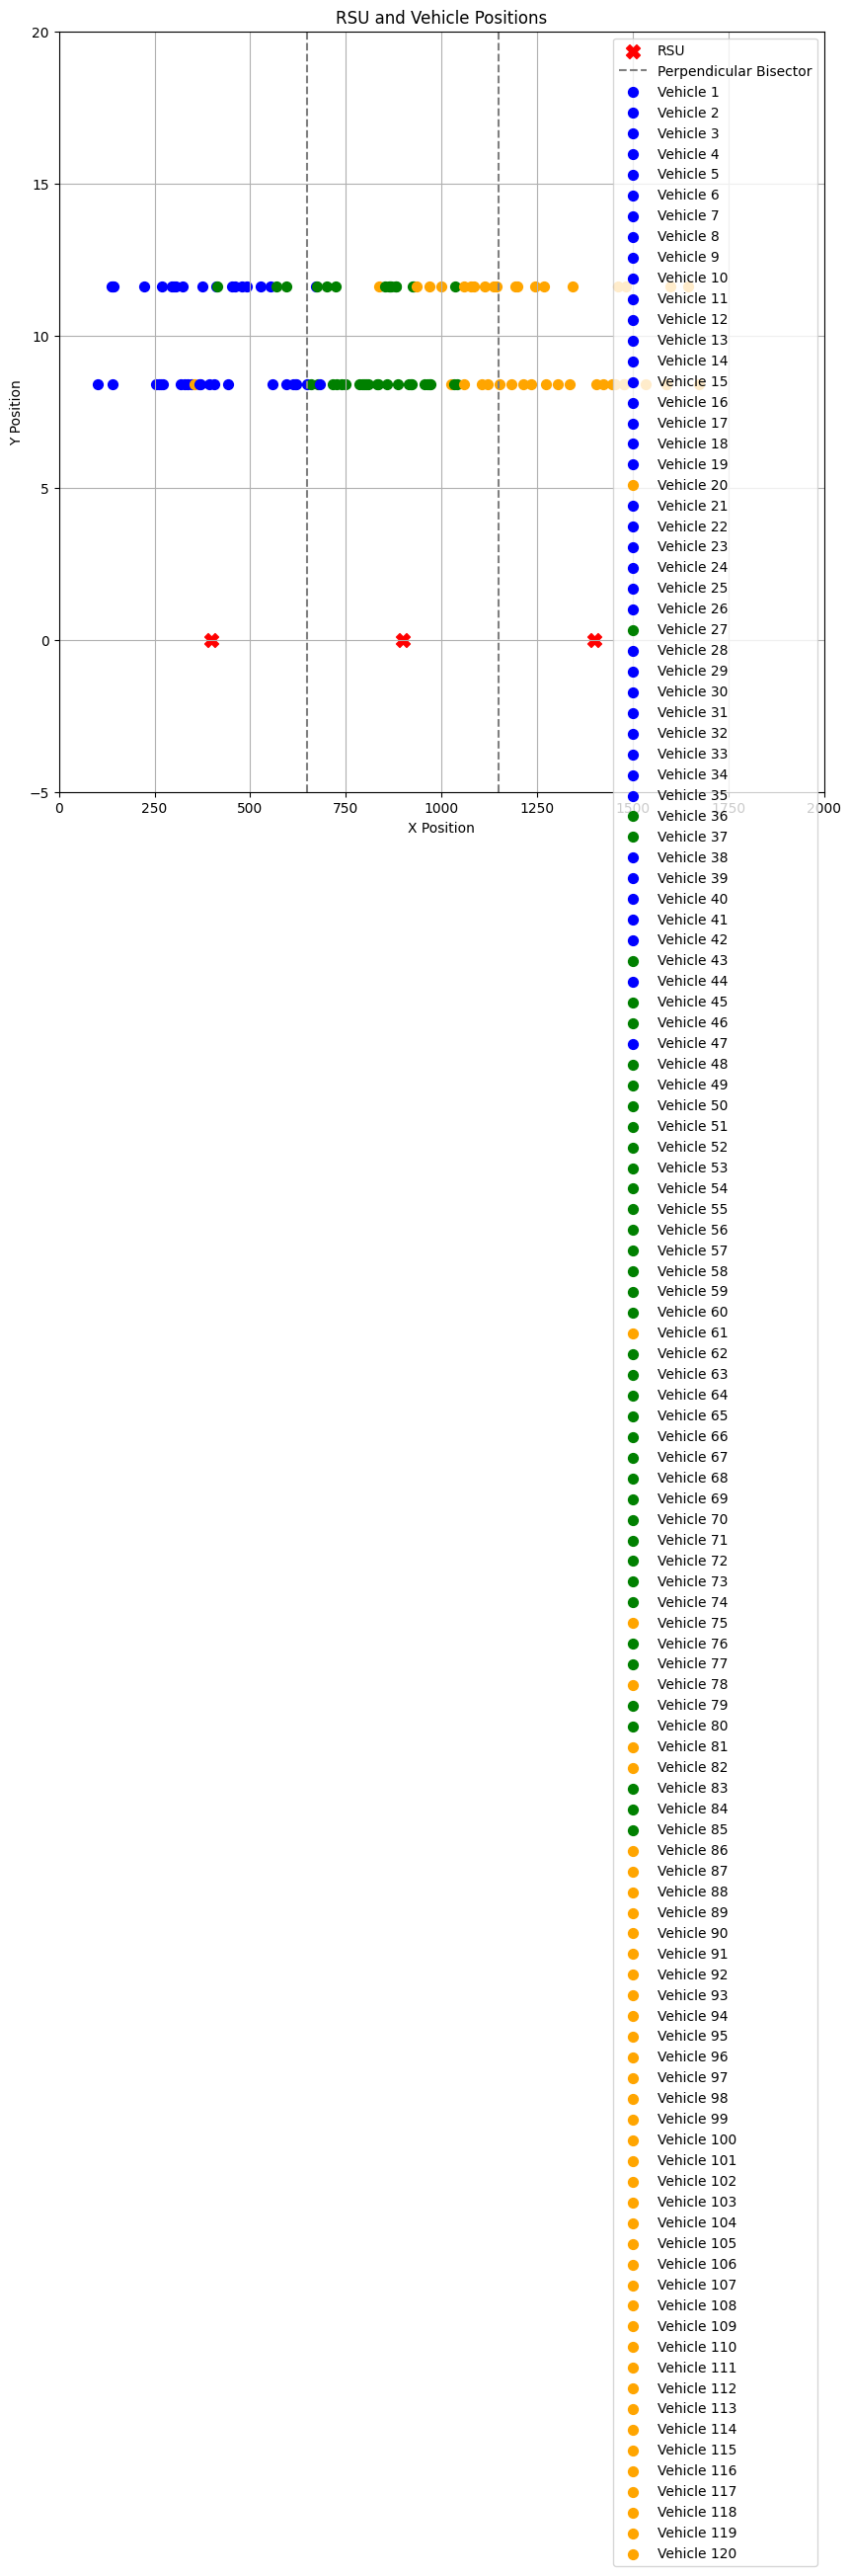

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th

def plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments=None):
    plt.figure(figsize=(10, 10))
    plt.xlim(0, 2000)
    plt.ylim(-5, 20)

    # RSUのプロット
    plt.scatter(rsu_positions[:, 0], rsu_positions[:, 1], c='red', label='RSU', s=100, marker='X')
    
    # RSU間の垂直二等分線をプロット
    for i in range(len(rsu_positions)-1):
        j = (i + 1)# 次のRSUのインデックス
        # 2つのRSU間の中点を計算
        mid_x = (rsu_positions[i, 0] + rsu_positions[j, 0]) / 2
        mid_y = (rsu_positions[i, 1] + rsu_positions[j, 1]) / 2
        
        # 元の線の傾きを計算
        dx = rsu_positions[j, 0] - rsu_positions[i, 0]
        dy = rsu_positions[j, 1] - rsu_positions[i, 1]
        
        if dy == 0:  # y座標が同じ場合（水平線）
            # 垂直二等分線は中点を通るy軸に平行な線
            plt.axvline(x=mid_x, color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)
        else:
            # 一般的な場合
            slope = -dx / dy  # 垂直二等分線の傾き
            intercept = mid_y - slope * mid_x  # y切片

            # プロット範囲でのx値を計算
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            x_vals = np.linspace(x_min, x_max, 500)
            y_vals = slope * x_vals + intercept

            # プロット範囲内のみ描画
            valid_indices = (y_vals >= y_min) & (y_vals <= y_max)
            plt.plot(x_vals[valid_indices], y_vals[valid_indices], color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)


    # 車両のプロット（ダミーデータを除外）
    for idx, vehicle_pos in enumerate(vehicle_positions):
        # ダミーデータを除外する条件
        if any(np.array_equal(vehicle_pos, rsu) for rsu in rsu_positions):
            continue  # ダミーデータはプロットしない

        # アクションに基づいた色設定
        if assignments[idx] is not None:
            color = ['blue', 'green', 'orange'][assignments[idx]]
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, label=f'Vehicle {idx + 1}', s=50)
            # plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, s=50)
        else:
            print('error')
            # plt.scatter(vehicle_pos[0], vehicle_pos[1], c='blue', label=f'Vehicle {idx + 1}', s=50)
            # plt.scatter(vehicle_pos[0], vehicle_pos[1], c='blue', s=50)


    plt.title('RSU and Vehicle Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    plt.legend()
    plt.grid()
    plt.show()



max_vehicles_num = 120

env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)
# 環境の初期化
obs = env.reset()
# obs = env.set_initial_vehicle_positions_random()

model_path = "./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v120_0.6_0.4_first_random_with_min20_ts50000"
model = A2C.load(model_path)

# 学習したモデルを用いてアクションを取得
assignments = model.predict(obs)[0]  # 各車両のアクションを取得
print(assignments)
# model.predict(obs)[0]において、0,1,2がそれぞれ何回出てくるかをカウントしてprintする
print(np.bincount(assignments))

rsu_positions = env.rsu_positions
vehicle_positions = env.vehicle_positions

# print(rsu_positions, vehicle_positions, assignments)



# プロットを表示
plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments)


IMMUによる車両の分配

In [ ]:
import re
import json
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import copy

def immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env):
	rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
    ])
	max_vehicle = 120
	while len(communicable_validator_list) < max_vehicle:
		# len(communicable_validator_list)がmax_vehicleになるまでrsu_positions[len(communicable_validator_list)%3]を追加
		communicable_validator_list.append("-1")
		validator_geographic_list.append(rsu_positions[len(communicable_validator_list)%3])
	
	print(communicable_validator_list)
	print(validator_geographic_list)
    # `validator_geographic_list`に基づいて`communicable_validator_list`と`validator_geographic_list`を並び替える
	sorted_lists = sorted(zip(communicable_validator_list, validator_geographic_list), key=lambda x: (x[1][0], x[1][1]))
	communicable_validator_list = [v for v, _ in sorted_lists]
	validator_geographic_list = [x for _, x in sorted_lists]

	# print("Sorted Communicable Validator List:", communicable_validator_list)
	# print("Sorted Validator Geographic List:", validator_geographic_list)

	# ここで、各validatorに対して、最も近いproposerを割り当てる
	obs = env.set_initial_vehicle_positions(np.array(validator_geographic_list))
	assignments = model.predict(obs)[0]
	print(assignments)
	print(np.bincount(assignments))
	

	assignments_result_json = []
	assignments_result_json.append([])
	assignments_result_json.append([])
	assignments_result_json.append([])
	for index, validator_id in enumerate(communicable_validator_list):
		if validator_id != "-1":
			assignments_result_json[assignments[index]].append(int(validator_id))

	for assignment in assignments_result_json:
		assignment.sort()
		

	return assignments_result_json
		
	

model_path = "./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v120_0.6_0.4_first_random_with_min20_ts50000"
model = A2C.load(model_path)

# read the json file
max_speed = 70 # km/hour
min_speed = 30
proposer_list = [0,1,2]

vehicle_assignment_result_timeline = {}
for proposer_id in proposer_list:
	vehicle_assignment_result_timeline[proposer_id] = {}
geographic_time_json = {}

for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/" + str(proposer_id) + "/"
	# log_foloder_path下のextended_time_geographic_data.jsonを読み込む
	extended_time_geographic_data_path = log_folder_path + "extended_time_geographic_data.json"
	with open(extended_time_geographic_data_path) as f:
		extended_time_geographic_data = json.load(f)
	geographic_time_json[proposer_id] = extended_time_geographic_data

# geographic_time_jsonのそれぞれの中身で共通のkeyを取得
common_keys = set(geographic_time_json[proposer_list[0]].keys())
for proposer_id in proposer_list:
	common_keys = common_keys & set(geographic_time_json[proposer_id].keys())
# listに直してsort
common_keys = list(common_keys)
# 中身を数値に直してソートをした後、strに直す
# strに直すとき絶対に小数点第2位まで表示される文字列にする
common_keys = [str("{:.2f}".format(float(num))) for num in sorted([float(num) for num in common_keys])]

print(common_keys)




# common_keysの中身を使って、各validatorに対して、最も近いproposerを割り当てる

old_grapchic_data = {}
now_grapchic_data = {}
old_vehicle_assignment_result = {}

for proposer_id in proposer_list:
	old_vehicle_assignment_result[proposer_id] = {}

for time_key in common_keys:
	communicable_validator_list = []
	validator_geographic_list = []
	
	for proposer_id in proposer_list:
		now_grapchic_data[proposer_id] = geographic_time_json[proposer_id][time_key]
	
	if old_grapchic_data == now_grapchic_data:
		for proposer_id in proposer_list:
			vehicle_assignment_result_timeline[proposer_id][time_key] = old_vehicle_assignment_result[proposer_id]
		continue

	# validatorに対して、最も近いproposerを割り当てる
	temporary_json = {}
	for proposer_id in proposer_list:
		for validator_id_item, validator_geographic_item in geographic_time_json[proposer_id][time_key].items():
			temporary_json[validator_id_item] = [float(num) for num in re.findall(r"[-+]?\d*\.\d+|\d+", validator_geographic_item)][:2]
	#temporary_json のkeyをcommunicable_validator_listに、valueをvalidator_geographic_listに格納
	for key, value in temporary_json.items():
		communicable_validator_list.append(key)
		validator_geographic_list.append(value)
	
	# ここで、各validatorに対して、最も近いproposerを割り当てる
	assignments_result_item = immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env)
	for proposer_id in proposer_list:
		vehicle_assignment_result_timeline[proposer_id][time_key] = assignments_result_item[proposer_id]
		old_vehicle_assignment_result[proposer_id] = assignments_result_item[proposer_id]
		print(vehicle_assignment_result_timeline[proposer_id][time_key])

	old_grapchic_data = copy.deepcopy(now_grapchic_data)

	#time_keyを50秒ごとに表示
	# if float(time_key) % 50 == 0:
	# 	print(time_key)
	print(time_key)

	# print(communicable_validator_list)
	# print(validator_geographic_list)

# immu_decided_participant_node_0or1or２.jsonに書き込む
for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/" + str(proposer_id) + "/"
	with open(log_folder_path + "immu_decided_participant_node_" + str(proposer_id) + ".json", "w") as f:
		json.dump(vehicle_assignment_result_timeline[proposer_id], f, indent=4)


参加者の分布を表す

[0, 0, 0, 0, 1, 2, 2, 3, 4, 4, 5, 5, 6, 7, 7, 8, 8, 9, 9, 7, 6, 6, 7, 6, 7, 8, 6, 8, 8, 8, 8, 9, 9, 9, 10, 9, 9, 11, 10, 9, 10, 9, 8, 10, 10, 9, 10, 10, 11, 9, 12, 10, 10, 9, 8, 8, 7, 8, 6, 6, 7, 6, 7, 6, 7, 7, 7, 9, 9, 9, 8, 8, 9, 9, 8, 9, 8, 9, 8, 8, 8, 8, 9, 10, 9, 10, 9, 10, 10, 11, 9, 9, 9, 10, 9, 9, 10, 9, 9, 9, 9, 10, 9, 9, 9, 10, 10, 9, 10, 9, 11, 10, 10, 10, 10, 9, 8, 11, 9, 7, 9, 8, 7, 7, 6, 6, 8, 7, 7, 6, 8, 7, 8, 8, 8, 8, 8, 11, 9, 9, 9, 8, 10, 9, 6, 8, 7, 8, 9, 9, 10, 11, 10, 12, 9, 12, 10, 10, 9, 10, 11, 9, 9, 9, 9, 9, 8, 10, 10, 8, 9, 9, 10, 10, 10, 9, 11, 11, 10, 10, 11, 11, 9, 10, 10, 10, 9, 8, 7, 6, 8, 7, 8, 8, 7, 7, 7, 7, 8, 8, 8, 8, 8, 8, 8, 9, 8, 9, 8, 9, 8, 8, 8, 8, 8, 8, 9, 10, 11, 11, 11, 10, 10, 10, 8, 10, 9, 9, 10, 9, 11, 11, 8, 11, 10, 11, 9, 9, 11, 9, 11, 10, 9, 11, 10, 12, 10, 10, 11, 10, 11, 10, 10, 8, 9, 8, 6, 7, 8, 7, 7, 8, 6, 7, 7, 7, 8, 8, 9, 8, 8, 8, 7, 6, 5, 5, 4, 4, 3, 3, 2, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 

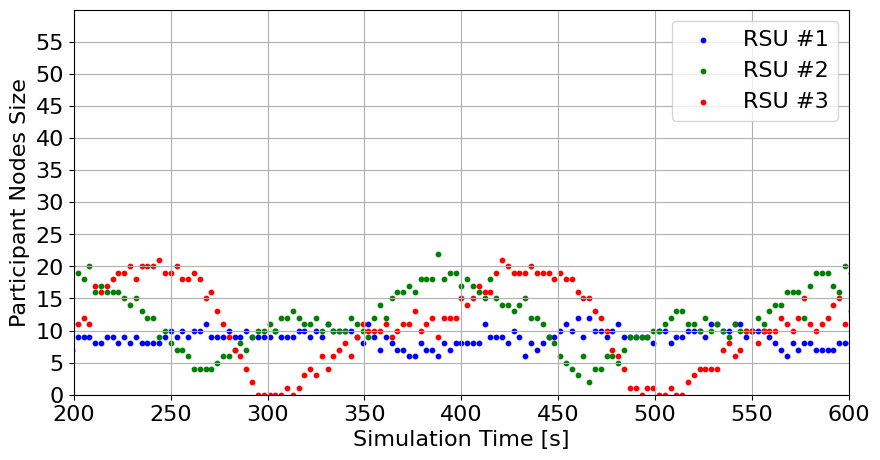

In [ ]:
import matplotlib.pyplot as plt
import json

def count_nodes_for_plot_in_multiple_scenario(proposer_id, log_folder_path):

    extracted_events_file_path = log_folder_path + str(proposer_id) + "/immu_decided_participant_node_" + str(proposer_id) + ".json"

    # extracted_events.json jsonデータを読み込む
    with open(extracted_events_file_path, 'r') as f:
        data = json.load(f)


    # グラフにプロットするデータを抽出
    time_series = []
    status_counts = []

    for time_key, participant_node_list in data.items():
        # print(participant_node_list)
        start_time = float(time_key)
        status_count = len(participant_node_list)
        time_series.append(start_time)
        status_counts.append(status_count)

    
    return time_series, status_counts

max_speed = 70
min_speed = 30
proposer_list = [0,1,2]
validator_num = 250
log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/"


# proposer_id 0
time_series, status_counts = count_nodes_for_plot_in_multiple_scenario(proposer_list[0], log_folder_path)

# proposer_id 1
time_series2, status_counts2 = count_nodes_for_plot_in_multiple_scenario(proposer_list[1], log_folder_path)

# proposer_id 2
time_series3, status_counts3 = count_nodes_for_plot_in_multiple_scenario(proposer_list[2], log_folder_path)

#time_series, status_countsたちを10個おきにする
time_series = time_series[::300]
status_counts = status_counts[::300]
time_series2 = time_series2[::300]
status_counts2 = status_counts2[::300]
time_series3 = time_series3[::300]
status_counts3 = status_counts3[::300]

print(status_counts)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
# plt.scatter(time_series, status_counts, facecolors='none', edgecolors='blue', marker='o', s=10, label='RSU No.1')
# plt.scatter(time_series2, status_counts2, facecolors='none', edgecolors='green', marker='o', s=10, label='RSU No.2')
# plt.scatter(time_series3, status_counts3, facecolors='none', edgecolors='red', marker='o', s=10, label='RSU No.3')
plt.scatter(time_series, status_counts, c='blue', marker='o', s=10, label='RSU #1')
plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10, label='RSU #2')
plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10, label='RSU #3')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('Participant Nodes Size', fontsize=16)

# plt.ylim(0, None)
# plt.xlim(0, 800)
plt.ylim(0, 60)
plt.xlim(200, 600)

plt.xticks(fontsize=16)
plt.yticks(range(0, 60, 5),fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()

学習の評価の重み付けを変えたときの比較実験

./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v120_0.6_0.4_first_random_with_min20_ts50000


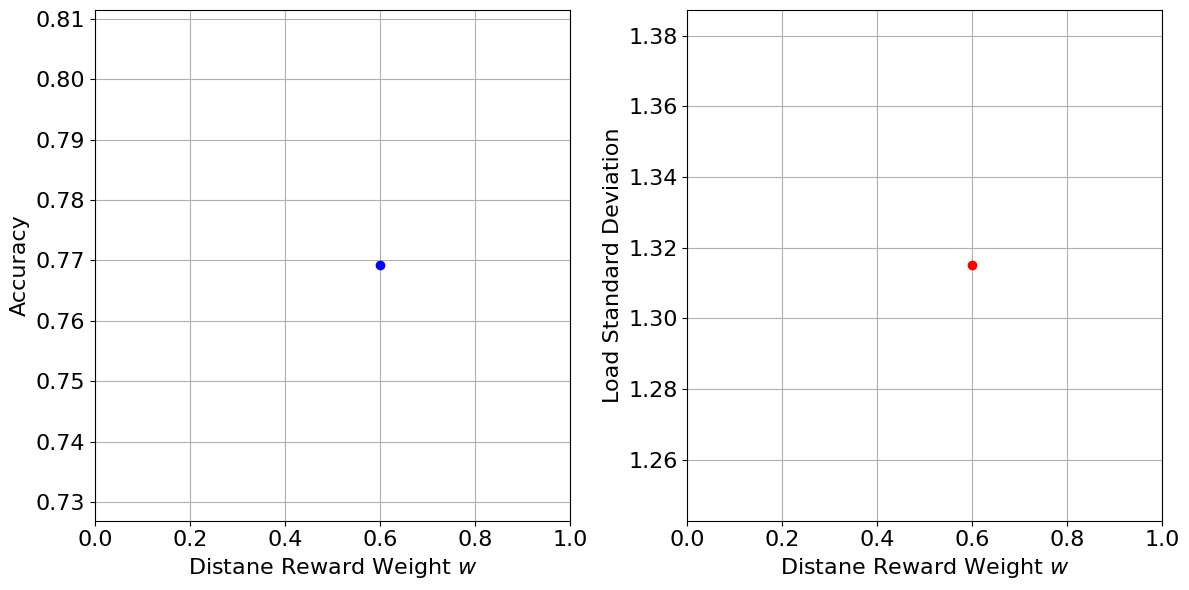

In [ ]:
from stable_baselines3 import A2C
from statistics import mean

def caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles):

    correct_assignments_sum = 0
    assignments_exteneded_list = []
    for i in range(int(sim_max_vehicles / env_max_vehicles)):
        # 環境の初期化
        obs = env.reset()

        # 学習したモデルを用いてアクションを取得
        assignments = model.predict(obs)[0]
        # print(assignments)

        # RSUの位置
        rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]              # 第3のRSUの位置
        ])



        # 正解率と標準偏差の計算
        correct_assignments = 0


        for idx, action in enumerate(assignments):
            vehicle_position = env.vehicle_positions[idx]
            distances = np.array([np.linalg.norm(vehicle_position - rsu) for rsu in rsu_positions])
            closest_rsu = np.argmin(distances)
            if action == closest_rsu:
                correct_assignments += 1


        correct_assignments_sum += correct_assignments

        # RSUごとの負荷を計算
        assignments_exteneded_list.extend(assignments)

    accuracy = correct_assignments_sum / (sim_max_vehicles)
    rsu_loads = np.bincount(assignments_exteneded_list, minlength=env.num_rsus)
    load_std_dev = np.std(rsu_loads)
    return accuracy, load_std_dev

def caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations):
    accuracy_list = []
    load_std_dev_list = []

    for i in range(num_evaluations):
        accuracy_item, load_std_dev_item = caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
    
    accuracy_average = mean(accuracy_list)
    load_std_dev_average = mean(load_std_dev_list)

    return accuracy_average, load_std_dev_average

env_max_vehicles = 120
sim_max_vehicles = 120

# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=env_max_vehicles)

# weight_list を用いてモデルをロードし、評価する
weight_list = [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
# weight_list = [0, 0.2, 0.4,1.0]
# weight_list = [1.0]
num_evaluations = 500
accuracy_list = []
load_std_dev_list = []
real_weight_list = []
for weight in weight_list:
    weight_1 = weight
    weight_2 = 1.0 - weight
    # model_path = f"a2c_vehicle_assignment_512*4_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}"
    model_path = f"./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}_first_random_with_min20_ts50000"
    try:
        model = A2C.load(model_path)
    except:
        continue
    accuracy_item, load_std_dev_item = caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations)
    accuracy_list.append(accuracy_item)
    load_std_dev_list.append(load_std_dev_item)
    real_weight_list.append(weight)
    print(model_path)


# 精度と負荷標準偏差のプロット
plt.figure(figsize=(12, 6))

# 精度のプロット
plt.subplot(1, 2, 1)
plt.plot(real_weight_list, accuracy_list, marker='o', linestyle='-', color='b')
plt.xlabel("Distane Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
plt.grid(True)

# 負荷標準偏差のプロット
plt.subplot(1, 2, 2)
plt.plot(real_weight_list, load_std_dev_list, marker='o', linestyle='-', color='r')
plt.xlabel("Distane Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel('Load Standard Deviation', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
plt.grid(True)

plt.tight_layout()
plt.show()



In [ ]:
model_path = f"./models/a2c/linear10/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v120_1.0_0.0_first_random_with_min20_ts50000"
# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=120)
try:
	model = A2C.load(model_path)
except:
	print("error")
accuracy_item, load_std_dev_item = caluculate_multi_spec_rl(env, model, 120, 120, 100)
print(accuracy_item, load_std_dev_item)

0.7055833333333333 6.332153357196996


# 新バージョン(max150, 1model)

envの読みこみ

In [13]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.min_space = -20
        self.max_space = 1800
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ

        # 観測空間を変更（速度情報を削除）
        # self.observation_space = spaces.Box(low=self.min_space, high=self.max_space, shape=(max_vehicles * 2,), dtype=np.float32)

        # RSU の位置情報も観測空間に含めるようにする
        self.observation_space = spaces.Box(
            low=self.min_space, 
            # high=self.max_space, 
            high=10000,
            shape=(self.max_vehicles * 3,), 
            dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        self.rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
        ])

    def set_initial_vehicle_positions(self, vehicle_positions):
        """
        車両の初期位置を設定する関数。観測空間内の位置に合わせて正しい形状で入力してください。
        max_vehicles以下の入力であれば、残りをダミーデータとして補完します。
        
        引数:
            vehicle_positions: 車両の位置リスト、shapeは(N, 2)で、範囲は[0, 100]（Nはmax_vehicles以下）
        """
        num_input_vehicles = vehicle_positions.shape[0]
        assert num_input_vehicles <= self.max_vehicles, "入力車両の数はmax_vehicles以下にしてください。"
        
        # ダミーデータを追加して max_vehicles に合わせる
        dummy_vehicle_positions = []
        for i in range(self.max_vehicles - num_input_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]
            dummy_vehicle_positions.append(rsu_pos)  # RSU周りに均等配置

        # 入力された車両位置とダミーデータを結合し、観測空間に合わせてクリップ
        #もしdummy_vehicle_positionsがからの場合、np.vstackでエラーが発生するので、if文で分岐
        if len(dummy_vehicle_positions) == 0:
            all_vehicle_positions = vehicle_positions
        else:
            all_vehicle_positions = np.vstack([vehicle_positions, dummy_vehicle_positions])
        self.vehicle_positions = np.clip(all_vehicle_positions, self.min_space, self.max_space)
        return self._get_observation()
    
    def set_initial_vehicle_positions_random(self, valid_num = -1):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        if valid_num != -1:
            num_valid_vehicles = valid_num
        else:
            num_valid_vehicles = random.randint(3, self.max_vehicles)
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []

        # ランダムな分割点を作成し、各人に割り当てるリンゴを計算
        min_vehicles_per_rsu = int(num_valid_vehicles // (self.num_rsus * 2))
        remaining_vehicles = num_valid_vehicles - (self.num_rsus * min_vehicles_per_rsu)
        allocations = [0] + sorted(random.choices(range(0, remaining_vehicles+1), k=self.num_rsus - 1)) + [remaining_vehicles]
        allocations = [allocations[i] - allocations[i - 1] for i in range(1, len(allocations))]
        allocations = [min_vehicles_per_rsu + add for add in allocations]
        allocations = [i for i, count in enumerate(allocations) for _ in range(count)]

        # 車両の位置を設定
        for allocation_item in allocations:
            if allocation_item == 0:
                x_position = np.random.uniform(100, 650)
            elif allocation_item == 1:
                x_position = np.random.uniform(650, 1150)
            elif allocation_item == 2:
                x_position = np.random.uniform(1150, 1700)
            y_position = np.random.choice([8.4, 11.6])
            vehicle_position = np.array([x_position, y_position, 0])
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            # rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            # self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定
            vehicle_position = np.array([10000, 10000, 1])
            self.vehicle_positions.append(vehicle_position)

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])
        self.vehicle_positions = np.array(self.vehicle_positions)

        return self._get_observation()

    def reset(self):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        num_valid_vehicles = random.randint(3, self.max_vehicles)
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []

        # ランダムな分割点を作成し、各人に割り当てるリンゴを計算
        min_vehicles_per_rsu = int(num_valid_vehicles // (self.num_rsus * 2))
        remaining_vehicles = num_valid_vehicles - (self.num_rsus * min_vehicles_per_rsu)
        allocations = [0] + sorted(random.choices(range(0, remaining_vehicles+1), k=self.num_rsus - 1)) + [remaining_vehicles]
        allocations = [allocations[i] - allocations[i - 1] for i in range(1, len(allocations))]
        allocations = [min_vehicles_per_rsu + add for add in allocations]
        allocations = [i for i, count in enumerate(allocations) for _ in range(count)]

        # 車両の位置を設定
        for allocation_item in allocations:
            if allocation_item == 0:
                x_position = np.random.uniform(100, 650)
            elif allocation_item == 1:
                x_position = np.random.uniform(650, 1150)
            elif allocation_item == 2:
                x_position = np.random.uniform(1150, 1700)
            y_position = np.random.choice([8.4, 11.6])
            vehicle_position = np.array([x_position, y_position, 0])
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            # rsu_pos = self.rsu_positions[i % self.num_rsus]  # ダミーデータもRSU周りに均等配置
            # self.vehicle_positions.append(rsu_pos)  # 位置をダミーデータとして設定
            vehicle_position = np.array([10000, 10000, 1])
            self.vehicle_positions.append(vehicle_position)

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])
        self.vehicle_positions = np.array(self.vehicle_positions)

        return self._get_observation()
    

    def step(self, actions):
        rewards = []
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ
        third_column = self.vehicle_positions[:, 2]
        first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)
        valid_vehicle_positions = self.vehicle_positions[:first_index]

        for idx in range(len(valid_vehicle_positions)):
            action = actions[idx]  # エージェントが選択したRSU

            # すべてのRSUとの距離を計算
            distances = np.array([np.linalg.norm(valid_vehicle_positions[idx][:2] - rsu) for rsu in self.rsu_positions])
            
            # 最短距離と最長距離を特定
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # 選択したRSUの距離
            selected_distance = distances[action]
            
            # 報酬の計算　No1
            # 報酬の計算（距離が離れるにつれ減少し、-1〜1の範囲に正規化）
            normalized_distance = (selected_distance - min_dist) / (max_dist - min_dist)
            reward = 1 - 2 * (normalized_distance)
            
            rewards.append(reward)

        # 距離報酬の合計
        actual_rewards = rewards  # ダミーデータの報酬を除外
        total_distance_reward = sum(actual_rewards) / len(actual_rewards)


        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions[:first_index], minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算

        if load_std_dev > 10:
            normalized_load_penalty =  -1
        else:
            normalized_load_penalty = 1 - 2 * (load_std_dev / 10)


        # 総合報酬の計算
        total_reward = 1.0 * total_distance_reward + 0.0 * normalized_load_penalty  # どちらも同じ重要度で加重平均


        self.current_step += 1  # ステップカウンタを増加
        done = self.current_step >= 1
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        # 車両の位置情報をフラットにしたものと、RSU の位置情報を結合する
        return np.array(self.vehicle_positions).flatten()
        # return np.concatenate([self.vehicle_positions.flatten(), self.rsu_positions.flatten()])

学習

In [14]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random


# 環境の作成
max_vehicles_num = 150
ent_coef_num = 0.003
learning_rate_num = 0.0001
total_timesteps_num = 150000

env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)

policy_kwargs = dict(net_arch=[512,512,512])

# A2Cエージェントの作成
model = A2C('MlpPolicy', env, learning_rate=learning_rate_num, verbose=1, ent_coef=ent_coef_num, policy_kwargs=policy_kwargs)

# Tensorboard ログの設定
log_dir = "./logs/a2c_tensorboard_512,512,512/1.0_0.0_linear10_v" + str(max_vehicles_num) + "_lrate" + str(learning_rate_num) + "_coef" + str(ent_coef_num) + "_nosort_with_dummy/"
new_logger = configure(log_dir, ["stdout", "tensorboard"])
model.set_logger(new_logger)

# トレーニング
model.learn(total_timesteps=total_timesteps_num)

# 学習したモデルを保存
model_path = "./a2c_vehicle_assignment_512*3_linear10_v" + str(max_vehicles_num) + "_1.0_0.0_nosort_with_dummy_ts" + str(total_timesteps_num) + ".zip"
model.save(model_path)

# 学習したモデルを評価
for episode in range(3):
    obs = env.reset()  # 初期状態を取得
    total_reward = 0  # エピソードごとの報酬を初期化
    done = False  # エピソードが終了していないフラグ

    for step in range(1):
        action = model.predict(obs)
        obs, reward, done, info = env.step(action[0])  # アクションを取得して環境に渡す
        total_reward += reward  # 報酬を累積

        if done:  # エピソードが終了したら
            print(f"Total reward for the episode: {total_reward}")  # エピソードの合計報酬を表示
            total_reward = 0  # エピソードごとの報酬をリセット
            obs = env.reset()  # 環境をリセット



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c_tensorboard_512,512,512/1.0_0.0_linear10_v150_lrate0.0001_coef0.003_nosort_with_dummy/
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.0588   |
| time/                 |          |
|    fps                | 51       |
|    iterations         | 100      |
|    time_elapsed       | 9        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -157     |
|    explained_variance | -4.26    |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 44.6     |
|    value_loss         | 0.128    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.0853   |
| time/             

In [ ]:
%reload_ext tensorboard
%tensorboard --logdir=/Users/villluc/Downloads/scenario/logs

単体テスト

[0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 1 2
 1 1 2 1 1 1 2 1 1 2 2 2 2 2 0 1 2 2 1 2 1 2 2 2 2 2 2 2 2 2 2 2 1 2 0] [20 29 23]
accuracy: 0.75


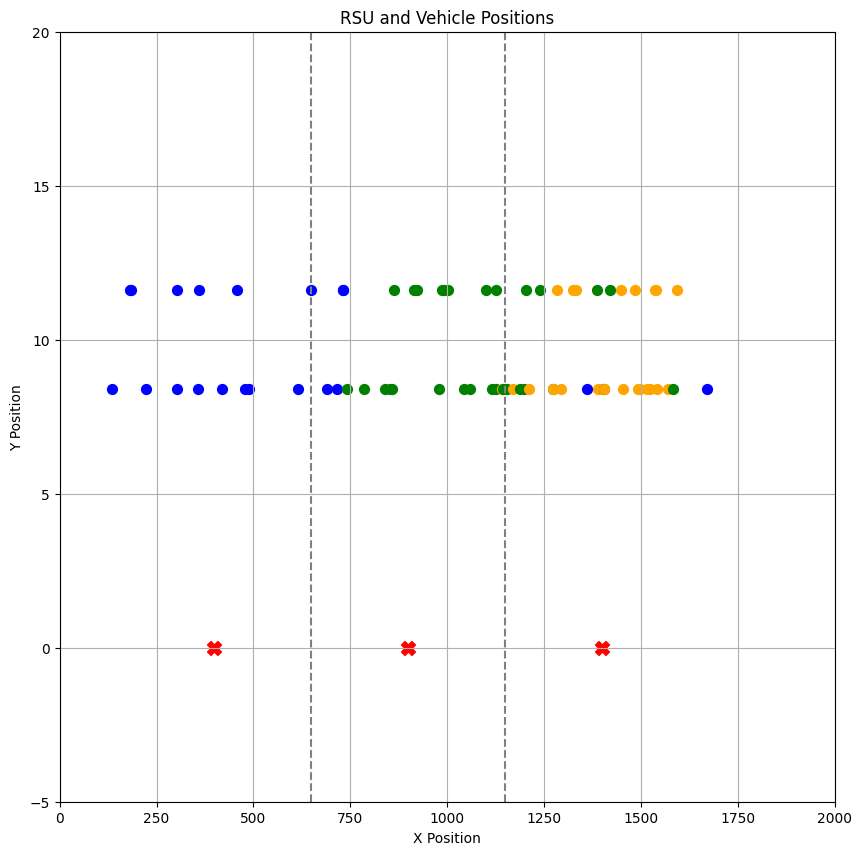

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th

def plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments=None):
    third_column = vehicle_positions[:, 2]
    first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)

    plt.figure(figsize=(10, 10))
    plt.xlim(0, 2000)
    plt.ylim(-5, 20)

    # RSUのプロット
    plt.scatter(rsu_positions[:, 0], rsu_positions[:, 1], c='red', label='RSU', s=100, marker='X')
    
    # RSU間の垂直二等分線をプロット
    for i in range(len(rsu_positions)-1):
        j = (i + 1)# 次のRSUのインデックス
        # 2つのRSU間の中点を計算
        mid_x = (rsu_positions[i, 0] + rsu_positions[j, 0]) / 2
        mid_y = (rsu_positions[i, 1] + rsu_positions[j, 1]) / 2
        
        # 元の線の傾きを計算
        dx = rsu_positions[j, 0] - rsu_positions[i, 0]
        dy = rsu_positions[j, 1] - rsu_positions[i, 1]
        
        if dy == 0:  # y座標が同じ場合（水平線）
            # 垂直二等分線は中点を通るy軸に平行な線
            plt.axvline(x=mid_x, color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)
        else:
            # 一般的な場合
            slope = -dx / dy  # 垂直二等分線の傾き
            intercept = mid_y - slope * mid_x  # y切片

            # プロット範囲でのx値を計算
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            x_vals = np.linspace(x_min, x_max, 500)
            y_vals = slope * x_vals + intercept

            # プロット範囲内のみ描画
            valid_indices = (y_vals >= y_min) & (y_vals <= y_max)
            plt.plot(x_vals[valid_indices], y_vals[valid_indices], color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)

    correct_assignments = 0

    # 車両のプロット（ダミーデータを除外）
    for idx, vehicle_pos in enumerate(vehicle_positions[:first_index]):
        # アクションに基づいた色設定
        if assignments[idx] is not None:
            color = ['blue', 'green', 'orange'][assignments[idx]]
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, label=f'Vehicle {idx + 1}', s=50)
        else:
            print('error')
        
        distances = np.array([np.linalg.norm(vehicle_pos[:2] - rsu) for rsu in rsu_positions])
        closest_rsu = np.argmin(distances)
        if assignments[idx] == closest_rsu:
            correct_assignments += 1

    
    print("accuracy: " + str(correct_assignments/first_index))


    plt.title('RSU and Vehicle Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    # plt.legend()
    plt.grid()
    plt.show()

    



max_vehicles_num = 150

env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)
# 環境の初期化
obs = env.reset()

model_path = "./models//a2c_vehicle_assignment_512*3_linear10_v150_1.0_0.0_nosort_with_dummy_ts100000"
model = A2C.load(model_path)

# 車両の位置を取得
rsu_positions = env.rsu_positions
vehicle_positions = env.vehicle_positions

third_column = vehicle_positions[:, 2]
first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)
valid_vehicle_positions = vehicle_positions[:first_index]

# 学習したモデルを用いてアクションを取得
assignments = model.predict(obs)[0]  # 各車両のアクションを取得

print(assignments[:first_index], np.bincount(assignments[:first_index]))

# プロットを表示
plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments)


IMMUによる車両配分

In [4]:
import re
import json
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import copy

def immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env):
	rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
    ])
	max_vehicle = 150

	for index, _ in enumerate(validator_geographic_list):
		validator_geographic_list[index].append(0)

	while len(communicable_validator_list) < max_vehicle:
		# len(communicable_validator_list)がmax_vehicleになるまでrsu_positions[len(communicable_validator_list)%3]を追加
		communicable_validator_list.append("-1")
		validator_geographic_list.append([10000, 10000, 1])
	
    # `validator_geographic_list`に基づいて`communicable_validator_list`と`validator_geographic_list`を並び替える
	sorted_lists = sorted(zip(communicable_validator_list, validator_geographic_list), key=lambda x: (x[1][0], x[1][1]))
	communicable_validator_list = [v for v, _ in sorted_lists]
	validator_geographic_list = [x for _, x in sorted_lists]

	# print(communicable_validator_list)
	# print(validator_geographic_list)

	# ここで、各validatorに対して、最も近いproposerを割り当てる
	obs = env.set_initial_vehicle_positions(np.array(validator_geographic_list))
	assignments = model.predict(obs)[0]
	# print(assignments)
	# print(np.bincount(assignments))
	

	assignments_result_json = []
	assignments_result_json.append([])
	assignments_result_json.append([])
	assignments_result_json.append([])
	for index, validator_id in enumerate(communicable_validator_list):
		if validator_id != "-1":
			assignments_result_json[assignments[index]].append(int(validator_id))

	for assignment in assignments_result_json:
		assignment.sort()
		

	return assignments_result_json
		
	

max_vehicles_num = 150
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)

# model_path = "./models/512*3_first_random_with_min20_with_dummy_ts100000/a2c_vehicle_assignment_512*3_linear10_v150_0.8_0.2_nosort_with_dummy_ts100000"
model_path = "a2c_vehicle_assignment_512*3_linear10_v150_0.6_0.4_nosort_with_dummy_ts150000"
model = A2C.load(model_path)

# read the json file
max_speed = 70 # km/hour
min_speed = 30
proposer_list = [0,1,2]

vehicle_assignment_result_timeline = {}
for proposer_id in proposer_list:
	vehicle_assignment_result_timeline[proposer_id] = {}
geographic_time_json = {}

for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/" + str(proposer_id) + "/"
	# log_foloder_path下のextended_time_geographic_data.jsonを読み込む
	extended_time_geographic_data_path = log_folder_path + "extended_time_geographic_data.json"
	with open(extended_time_geographic_data_path) as f:
		extended_time_geographic_data = json.load(f)
	geographic_time_json[proposer_id] = extended_time_geographic_data

# geographic_time_jsonのそれぞれの中身で共通のkeyを取得
common_keys = set(geographic_time_json[proposer_list[0]].keys())
for proposer_id in proposer_list:
	common_keys = common_keys & set(geographic_time_json[proposer_id].keys())
# listに直してsort
common_keys = list(common_keys)
# 中身を数値に直してソートをした後、strに直す
# strに直すとき絶対に小数点第2位まで表示される文字列にする
common_keys = [str("{:.2f}".format(float(num))) for num in sorted([float(num) for num in common_keys])]

print(common_keys)




# common_keysの中身を使って、各validatorに対して、最も近いproposerを割り当てる

old_grapchic_data = {}
now_grapchic_data = {}
old_vehicle_assignment_result = {}

for proposer_id in proposer_list:
	old_vehicle_assignment_result[proposer_id] = {}

for time_key in common_keys:
	communicable_validator_list = []
	validator_geographic_list = []
	
	for proposer_id in proposer_list:
		now_grapchic_data[proposer_id] = geographic_time_json[proposer_id][time_key]
	
	if old_grapchic_data == now_grapchic_data:
		for proposer_id in proposer_list:
			vehicle_assignment_result_timeline[proposer_id][time_key] = old_vehicle_assignment_result[proposer_id]
		continue

	# validatorに対して、最も近いproposerを割り当てる
	temporary_json = {}
	for proposer_id in proposer_list:
		for validator_id_item, validator_geographic_item in geographic_time_json[proposer_id][time_key].items():
			temporary_json[validator_id_item] = [float(num) for num in re.findall(r"[-+]?\d*\.\d+|\d+", validator_geographic_item)][:2]
	#temporary_json のkeyをcommunicable_validator_listに、valueをvalidator_geographic_listに格納
	for key, value in temporary_json.items():
		communicable_validator_list.append(key)
		validator_geographic_list.append(value)
	
	# ここで、各validatorに対して、最も近いproposerを割り当てる
	assignments_result_item = immu_vehicle_assignment(communicable_validator_list, validator_geographic_list, model, env)
	for proposer_id in proposer_list:
		vehicle_assignment_result_timeline[proposer_id][time_key] = assignments_result_item[proposer_id]
		old_vehicle_assignment_result[proposer_id] = assignments_result_item[proposer_id]
		# print(vehicle_assignment_result_timeline[proposer_id][time_key])

	old_grapchic_data = copy.deepcopy(now_grapchic_data)

	print(time_key)


# immu_decided_participant_node_0or1or２.jsonに書き込む
for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/" + str(proposer_id) + "/"
	with open(log_folder_path + "immu_wd_decided_participant_node_" + str(proposer_id) + ".json", "w") as f:
		json.dump(vehicle_assignment_result_timeline[proposer_id], f, indent=4)


['1.02', '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.10', '1.11', '1.12', '1.13', '1.14', '1.15', '1.16', '1.17', '1.18', '1.19', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.28', '1.29', '1.30', '1.31', '1.32', '1.33', '1.34', '1.35', '1.36', '1.37', '1.38', '1.39', '1.40', '1.41', '1.42', '1.43', '1.44', '1.45', '1.46', '1.47', '1.48', '1.49', '1.50', '1.51', '1.52', '1.53', '1.54', '1.55', '1.56', '1.57', '1.58', '1.59', '1.60', '1.61', '1.62', '1.63', '1.64', '1.65', '1.66', '1.67', '1.68', '1.69', '1.70', '1.71', '1.72', '1.73', '1.74', '1.75', '1.76', '1.77', '1.78', '1.79', '1.80', '1.81', '1.82', '1.83', '1.84', '1.85', '1.86', '1.87', '1.88', '1.89', '1.90', '1.91', '1.92', '1.93', '1.94', '1.95', '1.96', '1.97', '1.98', '1.99', '2.00', '2.01', '2.02', '2.03', '2.04', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10', '2.11', '2.12', '2.13', '2.14', '2.15', '2.16', '2.17', '2.18', '2.19', '2.20', '2.21', '2.22', '2.23', '2.24', '2.25', '2.26',

## 参加者の分布表示

[0, 0, 0, 0, 1, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 4, 3, 4, 4, 3, 4, 5, 4, 5, 4, 5, 4, 6, 6, 6, 7, 7, 8, 6, 7, 6, 7, 8, 9, 8, 7, 8, 8, 8, 7, 10, 9, 9, 9, 11, 11, 10, 9, 9, 10, 10, 13, 12, 13, 11, 12, 11, 11, 12, 14, 12, 12, 12, 14, 14, 16, 14, 10, 12, 15, 13, 12, 13, 13, 10, 12, 8, 10, 11, 11, 8, 8, 8, 8, 8, 7, 5, 6, 5, 5, 6, 5, 8, 7, 7, 7, 6, 8, 7, 9, 9, 9, 9, 9, 7, 9, 9, 9, 9, 10, 10, 10, 9, 10, 10, 11, 10, 12, 10, 11, 13, 10, 12, 14, 12, 12, 13, 14, 13, 15, 15, 17, 15, 14, 12, 14, 13, 12, 12, 11, 10, 12, 12, 12, 10, 11, 8, 8, 10, 9, 6, 5, 5, 6, 4, 4, 5, 6, 6, 9, 7, 7, 6, 8, 8, 8, 8, 8, 8, 10, 8, 10, 7, 10, 10, 8, 12, 9, 11, 9, 10, 9, 11, 12, 11, 11, 15, 13, 14, 12, 12, 14, 11, 13, 14, 13, 14, 13, 12, 17, 14, 14, 12, 12, 10, 11, 11, 10, 12, 11, 8, 8, 10, 9, 9, 6, 7, 7, 5, 5, 6, 5, 5, 5, 6, 8, 8, 8, 9, 7, 7, 7, 8, 7, 8, 8, 10, 7, 9, 9, 9, 9, 10, 11, 11, 11, 11, 11, 10, 11, 12, 12, 14, 10, 10, 11, 11, 12, 11, 11, 14, 13, 12, 14, 14, 12, 8, 14, 12, 12, 10, 9, 11, 8, 9, 8, 4, 7, 5

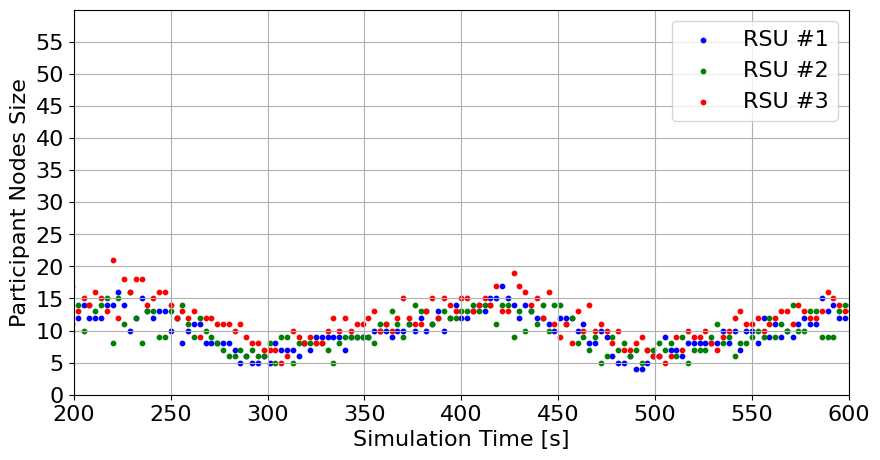

In [6]:
import matplotlib.pyplot as plt
import json

def count_nodes_for_plot_in_multiple_scenario(proposer_id, log_folder_path):

    extracted_events_file_path = log_folder_path + str(proposer_id) + "/immu_wd_decided_participant_node_" + str(proposer_id) + ".json"

    # extracted_events.json jsonデータを読み込む
    with open(extracted_events_file_path, 'r') as f:
        data = json.load(f)


    # グラフにプロットするデータを抽出
    time_series = []
    status_counts = []

    for time_key, participant_node_list in data.items():
        # print(participant_node_list)
        start_time = float(time_key)
        status_count = len(participant_node_list)
        time_series.append(start_time)
        status_counts.append(status_count)

    
    return time_series, status_counts

max_speed = 70
min_speed = 30
proposer_list = [0,1,2]
validator_num = 250
log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/160vehicle/"


# proposer_id 0
time_series, status_counts = count_nodes_for_plot_in_multiple_scenario(proposer_list[0], log_folder_path)

# proposer_id 1
time_series2, status_counts2 = count_nodes_for_plot_in_multiple_scenario(proposer_list[1], log_folder_path)

# proposer_id 2
time_series3, status_counts3 = count_nodes_for_plot_in_multiple_scenario(proposer_list[2], log_folder_path)

#time_series, status_countsたちを10個おきにする
time_series = time_series[::300]
status_counts = status_counts[::300]
time_series2 = time_series2[::300]
status_counts2 = status_counts2[::300]
time_series3 = time_series3[::300]
status_counts3 = status_counts3[::300]

print(status_counts)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
# plt.scatter(time_series, status_counts, facecolors='none', edgecolors='blue', marker='o', s=10, label='RSU No.1')
# plt.scatter(time_series2, status_counts2, facecolors='none', edgecolors='green', marker='o', s=10, label='RSU No.2')
# plt.scatter(time_series3, status_counts3, facecolors='none', edgecolors='red', marker='o', s=10, label='RSU No.3')
plt.scatter(time_series, status_counts, c='blue', marker='o', s=10, label='RSU #1')
plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10, label='RSU #2')
plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10, label='RSU #3')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('Participant Nodes Size', fontsize=16)

# plt.ylim(0, None)
# plt.xlim(0, 800)
plt.ylim(0, 60)
plt.xlim(200, 600)

plt.xticks(fontsize=16)
plt.yticks(range(0, 60, 5),fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()

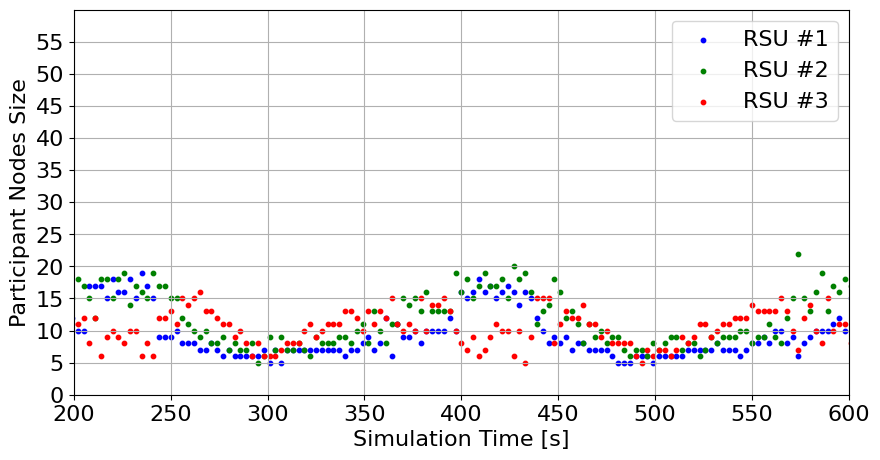

学習の評価の重み付けを変えたときの比較実験

a2c_vehicle_assignment_512*3_linear10_v150_0.6_0.4_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.8_0.2_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_1.0_0.0_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.6_0.4_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.8_0.2_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_1.0_0.0_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.6_0.4_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.8_0.2_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_1.0_0.0_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.6_0.4_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_0.8_0.2_nosort_with_dummy_ts150000
a2c_vehicle_assignment_512*3_linear10_v150_1.0_0.0_nosort_with_dummy_ts150000


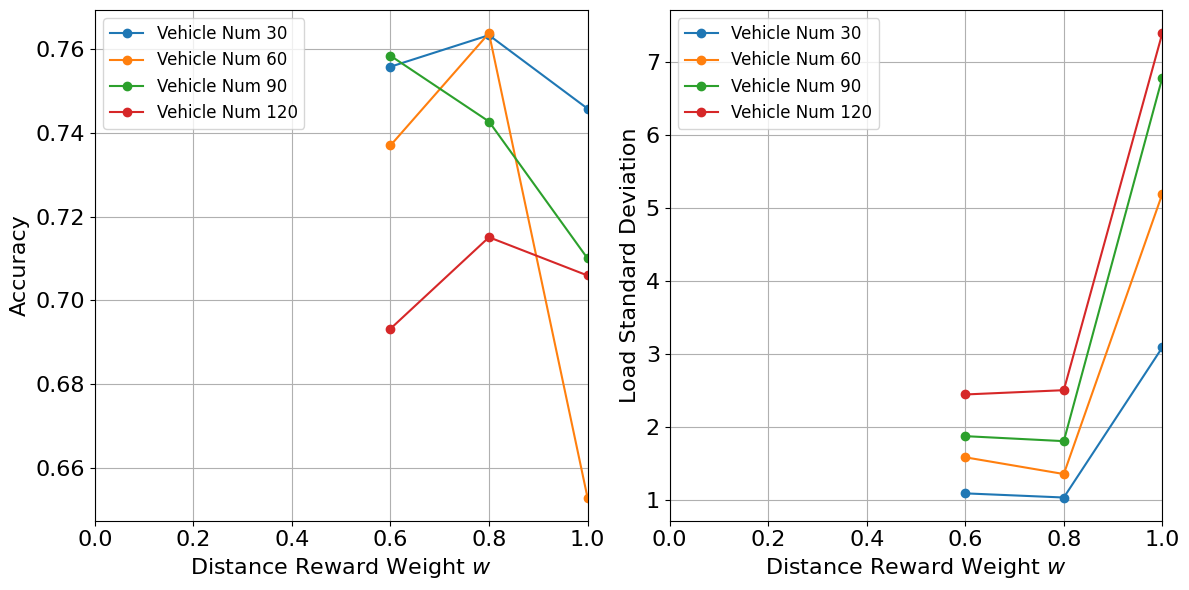

In [16]:
from stable_baselines3 import A2C
from statistics import mean

def caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, valid_vehicle_num):

    correct_assignments_sum = 0
    assignments_exteneded_list = []
    for i in range(int(sim_max_vehicles / env_max_vehicles)):
        # 環境の初期化
        obs = env.set_initial_vehicle_positions_random(valid_vehicle_num)

        third_column = env.vehicle_positions[:, 2]
        first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)

        # 学習したモデルを用いてアクションを取得
        assignments = model.predict(obs)[0]

        # RSUの位置
        rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]              # 第3のRSUの位置
        ])

        # 正解率と標準偏差の計算
        correct_assignments = 0

        for idx, action in enumerate(assignments[:first_index]):
            vehicle_position = env.vehicle_positions[idx]
            distances = np.array([np.linalg.norm(vehicle_position[:2] - rsu) for rsu in rsu_positions])
            closest_rsu = np.argmin(distances)
            if action == closest_rsu:
                correct_assignments += 1


        correct_assignments_sum += correct_assignments

        # RSUごとの負荷を計算
        assignments_exteneded_list.extend(assignments[:first_index])

    accuracy = correct_assignments_sum / (first_index)
    rsu_loads = np.bincount(assignments_exteneded_list, minlength=env.num_rsus)
    load_std_dev = np.std(rsu_loads)
    return accuracy, load_std_dev

def caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations, valid_vehicle_num):
    accuracy_list = []
    load_std_dev_list = []

    for i in range(num_evaluations):
        accuracy_item, load_std_dev_item = caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, valid_vehicle_num)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
    
    accuracy_average = mean(accuracy_list)
    load_std_dev_average = mean(load_std_dev_list)

    return accuracy_average, load_std_dev_average

env_max_vehicles = 150
sim_max_vehicles = 150

# 環境の作成
env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=env_max_vehicles)

# weight_list を用いてモデルをロードし、評価する
weight_list = [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
vehicle_num_list = [30, 60, 90, 120]
num_evaluations = 500
accuracy_2list = []
load_std_dev_2list = []
real_weight_list = []
for vehicle_num in vehicle_num_list:
    accuracy_list = []
    load_std_dev_list = []
    for weight in weight_list:
        weight_1 = weight
        weight_2 = 1.0 - weight
        model_path = f"a2c_vehicle_assignment_512*3_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}_nosort_with_dummy_ts150000"
        # model_path = f"./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}_first_random_with_min20_ts50000"
        try:
            model = A2C.load(model_path)
        except:
            continue
        accuracy_item, load_std_dev_item = caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations, vehicle_num)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
        if len(accuracy_2list) ==0 :
            real_weight_list.append(weight)
        print(model_path)
    accuracy_2list.append(accuracy_list)
    load_std_dev_2list.append(load_std_dev_list)


# # 精度と負荷標準偏差のプロット
# plt.figure(figsize=(12, 6))

# # 精度のプロット
# plt.subplot(1, 2, 1)
# plt.plot(real_weight_list, accuracy_list, marker='o', linestyle='-', color='b')
# plt.xlabel("Distane Reward Weight " + r"$\mathit{w}$", fontsize=16)
# plt.ylabel('Accuracy', fontsize=16)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlim(0, 1.0)
# plt.grid(True)

# # 負荷標準偏差のプロット
# plt.subplot(1, 2, 2)
# plt.plot(real_weight_list, load_std_dev_list, marker='o', linestyle='-', color='r')
# plt.xlabel("Distane Reward Weight " + r"$\mathit{w}$", fontsize=16)
# plt.ylabel('Load Standard Deviation', fontsize=16)
# plt.xticks(fontsize=16)
# plt.yticks(fontsize=16)
# plt.xlim(0, 1.0)
# plt.grid(True)

# plt.tight_layout()
# plt.show()

# 精度と負荷標準偏差のプロット
plt.figure(figsize=(12, 6))

# 精度のプロット
plt.subplot(1, 2, 1)
for i, vehicle_num in enumerate(vehicle_num_list):
    plt.plot(real_weight_list, accuracy_2list[i], marker='o', linestyle='-', label=f'Vehicle Num {vehicle_num}')
plt.xlabel("Distance Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel('Accuracy', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
plt.legend(fontsize=12)
plt.grid(True)

# 負荷標準偏差のプロット
plt.subplot(1, 2, 2)
for i, vehicle_num in enumerate(vehicle_num_list):
    plt.plot(real_weight_list, load_std_dev_2list[i], marker='o', linestyle='-', label=f'Vehicle Num {vehicle_num}')
plt.xlabel("Distance Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel('Load Standard Deviation', fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()




# 新バージョン2(max135.105,75,45, 4model使い分け)

In [2]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random

class VehicleAssignmentEnv(gym.Env):
    def __init__(self, num_rsus=3, max_vehicles=10, distance_reward_weight=0.6):
        super(VehicleAssignmentEnv, self).__init__()
        self.num_rsus = num_rsus
        self.max_vehicles = max_vehicles
        self.min_space = -20
        self.max_space = 1800
        self.current_step = 0  # 現在のステップを追跡
        self.episode_count = 0  # エピソードごとのカウンタ
        self.distance_reward_weight = distance_reward_weight

        # 観測空間を変更（速度情報を削除）
        # self.observation_space = spaces.Box(low=self.min_space, high=self.max_space, shape=(max_vehicles * 2,), dtype=np.float32)

        # RSU の位置情報も観測空間に含めるようにする
        self.observation_space = spaces.Box(
            low=self.min_space, 
            # high=self.max_space, 
            high=10000,
            shape=(self.max_vehicles * 3,), 
            dtype=np.float32
        )
        self.action_space = spaces.MultiDiscrete([num_rsus] * max_vehicles)

        # RSUの位置を固定 (簡単な正三角形配置)
        self.rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
        ])

    def set_initial_vehicle_positions(self, vehicle_positions):
        """
        車両の初期位置を設定する関数。観測空間内の位置に合わせて正しい形状で入力してください。
        max_vehicles以下の入力であれば、残りをダミーデータとして補完します。
        
        引数:
            vehicle_positions: 車両の位置リスト、shapeは(N, 2)で、範囲は[0, 100]（Nはmax_vehicles以下）
        """
        num_input_vehicles = vehicle_positions.shape[0]
        assert num_input_vehicles <= self.max_vehicles, "入力車両の数はmax_vehicles以下にしてください。"
        
        # ダミーデータを追加して max_vehicles に合わせる
        dummy_vehicle_positions = []
        for i in range(self.max_vehicles - num_input_vehicles):
            rsu_pos = self.rsu_positions[i % self.num_rsus]
            dummy_vehicle_positions.append(rsu_pos)  # RSU周りに均等配置

        # 入力された車両位置とダミーデータを結合し、観測空間に合わせてクリップ
        #もしdummy_vehicle_positionsがからの場合、np.vstackでエラーが発生するので、if文で分岐
        if len(dummy_vehicle_positions) == 0:
            all_vehicle_positions = vehicle_positions
        else:
            all_vehicle_positions = np.vstack([vehicle_positions, dummy_vehicle_positions])
        self.vehicle_positions = np.clip(all_vehicle_positions, self.min_space, self.max_space)
        return self._get_observation()
    
    def set_initial_vehicle_positions_random(self, valid_num = -1):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        # num_valid_vehicles = np.random.randint(50, self.max_vehicles + 1)  # 0からmax_vehiclesの間でランダムに決定
        if valid_num != -1:
            num_valid_vehicles = valid_num
        else:
            num_valid_vehicles = random.randint(self.max_vehicles - 30, self.max_vehicles)
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []

        # ランダムな分割点を作成し、各人に割り当てるリンゴを計算
        min_vehicles_per_rsu = int(num_valid_vehicles // (self.num_rsus * 2))
        remaining_vehicles = num_valid_vehicles - (self.num_rsus * min_vehicles_per_rsu)
        allocations = [0] + sorted(random.choices(range(0, remaining_vehicles+1), k=self.num_rsus - 1)) + [remaining_vehicles]
        allocations = [allocations[i] - allocations[i - 1] for i in range(1, len(allocations))]
        allocations = [min_vehicles_per_rsu + add for add in allocations]
        allocations = [i for i, count in enumerate(allocations) for _ in range(count)]

        # 車両の位置を設定
        for allocation_item in allocations:
            if allocation_item == 0:
                x_position = np.random.uniform(100, 650)
            elif allocation_item == 1:
                x_position = np.random.uniform(650, 1150)
            elif allocation_item == 2:
                x_position = np.random.uniform(1150, 1700)
            y_position = np.random.choice([8.4, 11.6])
            vehicle_position = np.array([x_position, y_position, 0])
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            vehicle_position = np.array([10000, 10000, 1])
            self.vehicle_positions.append(vehicle_position)

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])
        self.vehicle_positions = np.array(self.vehicle_positions)

        return self._get_observation()

    def reset(self, valid_num = -1):
        self.current_step = 0  # ステップカウンタをリセット
        self.episode_count += 1  # エピソード数を増加

        # 正規データの数をランダムに決定
        if valid_num != -1:
            num_valid_vehicles = valid_num
        else:
            num_valid_vehicles = random.randint(self.max_vehicles - 30, self.max_vehicles)
        num_dummy_vehicles = self.max_vehicles - num_valid_vehicles  # 残りをダミーデータとして扱う

        # 車両の位置を設定
        self.vehicle_positions = []

        # ランダムな分割点を作成し、各人に割り当てるリンゴを計算
        min_vehicles_per_rsu = int(num_valid_vehicles // (self.num_rsus * 2))
        remaining_vehicles = num_valid_vehicles - (self.num_rsus * min_vehicles_per_rsu)
        allocations = [0] + sorted(random.choices(range(0, remaining_vehicles+1), k=self.num_rsus - 1)) + [remaining_vehicles]
        allocations = [allocations[i] - allocations[i - 1] for i in range(1, len(allocations))]
        allocations = [min_vehicles_per_rsu + add for add in allocations]
        allocations = [i for i, count in enumerate(allocations) for _ in range(count)]

        # 車両の位置を設定
        for allocation_item in allocations:
            if allocation_item == 0:
                x_position = np.random.uniform(100, 650)
            elif allocation_item == 1:
                x_position = np.random.uniform(650, 1150)
            elif allocation_item == 2:
                x_position = np.random.uniform(1150, 1700)
            y_position = np.random.choice([8.4, 11.6])
            vehicle_position = np.array([x_position, y_position, 0])
            self.vehicle_positions.append(vehicle_position)

        # ダミーデータをRSUに均等に割り当てる
        for i in range(num_dummy_vehicles):
            vehicle_position = np.array([10000, 10000, 1])
            self.vehicle_positions.append(vehicle_position)

        # ランダムに生成した車両の位置とダミーデータをx座標でソート
        self.vehicle_positions = sorted(self.vehicle_positions, key=lambda pos: pos[0])
        self.vehicle_positions = np.array(self.vehicle_positions)

        return self._get_observation()
    

    def step(self, actions):
        rewards = []
        min_distance = 0.01  # 最小値を定義してゼロ割りを防ぐ
        third_column = self.vehicle_positions[:, 2]
        first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)
        valid_vehicle_positions = self.vehicle_positions[:first_index]

        for idx in range(len(valid_vehicle_positions)):
            action = actions[idx]  # エージェントが選択したRSU

            # すべてのRSUとの距離を計算
            distances = np.array([np.linalg.norm(valid_vehicle_positions[idx][:2] - rsu) for rsu in self.rsu_positions])
            
            # 最短距離と最長距離を特定
            min_dist = np.min(distances)
            max_dist = np.max(distances)
            
            # 選択したRSUの距離
            selected_distance = distances[action]
            
            # 報酬の計算　No1
            # 報酬の計算（距離が離れるにつれ減少し、-1〜1の範囲に正規化）
            normalized_distance = (selected_distance - min_dist) / (max_dist - min_dist)
            reward = 1 - 2 * (normalized_distance)
            
            rewards.append(reward)

        # 距離報酬の合計
        actual_rewards = rewards  # ダミーデータの報酬を除外
        total_distance_reward = sum(actual_rewards) / len(actual_rewards)


        # 負荷バランスを考慮したペナルティの計算（標準偏差を使用）
        rsu_loads = np.bincount(actions[:first_index], minlength=self.num_rsus)
        load_std_dev = np.std(rsu_loads)  # 負荷の標準偏差を計算

        if load_std_dev > 10:
            normalized_load_penalty =  -1
        else:
            normalized_load_penalty = 1 - 2 * (load_std_dev / 10)


        # 総合報酬の計算
        total_reward = self.distance_reward_weight * total_distance_reward + (1-self.distance_reward_weight) * normalized_load_penalty  # どちらも同じ重要度で加重平均


        self.current_step += 1  # ステップカウンタを増加
        done = self.current_step >= 1
        return self._get_observation(), total_reward, done, {}

    def _get_observation(self):
        # 位置情報のみを返す
        # 車両の位置情報をフラットにしたものと、RSU の位置情報を結合する
        return np.array(self.vehicle_positions).flatten()
        # return np.concatenate([self.vehicle_positions.flatten(), self.rsu_positions.flatten()])

学習

In [146]:
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th
import random


# 環境の作成
max_vehicles_num_list = [45, 75, 105]
ent_coef_num = 0.003
learning_rate_num = 0.0001
total_timesteps_num = 50000
# distance_reward_weight_list = [0, 0.2, 0.4, 0.6, 0.8, 1.0]
distance_reward_weight_list = [0, 0.2]




for max_vehicles_num in max_vehicles_num_list:
    for distance_reward_weight in distance_reward_weight_list:
        env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num, distance_reward_weight=distance_reward_weight)
        policy_kwargs = dict(net_arch=[512,512,512])
        # A2Cエージェントの作成
        model = A2C('MlpPolicy', env, learning_rate=learning_rate_num, verbose=1, ent_coef=ent_coef_num, policy_kwargs=policy_kwargs)


        weight_1 = distance_reward_weight
        weight_2 = 1.0 - distance_reward_weight

        # Tensorboard ログの設定
        log_dir = f"./logs/a2c_tensorboard_512,512,512/{weight_1:.1f}_{weight_2:.1f}_linear10_v{str(max_vehicles_num)}_lrate{str(learning_rate_num)}_coef{str(ent_coef_num)}_nosort_with_dummyu30/"
        new_logger = configure(log_dir, ["stdout", "tensorboard"])
        model.set_logger(new_logger)

        # トレーニング
        model.learn(total_timesteps=total_timesteps_num)

        # 学習したモデルを保存
        model_path = f"./a2c_vehicle_assignment_512*3_linear10_v{str(max_vehicles_num)}_{weight_1:.1f}_{weight_2:.1f}_nosort_with_dummyu30_ts{str(total_timesteps_num)}.zip"
        model.save(model_path)

        # 学習したモデルを評価
        for episode in range(3):
            obs = env.reset()  # 初期状態を取得
            total_reward = 0  # エピソードごとの報酬を初期化
            done = False  # エピソードが終了していないフラグ

            for step in range(1):
                action = model.predict(obs)
                obs, reward, done, info = env.step(action[0])  # アクションを取得して環境に渡す
                total_reward += reward  # 報酬を累積

                if done:  # エピソードが終了したら
                    print(f"Total reward for the episode: {total_reward}")  # エピソードの合計報酬を表示
                    total_reward = 0  # エピソードごとの報酬をリセット
                    obs = env.reset()  # 環境をリセット



Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Logging to ./logs/a2c_tensorboard_512,512,512/0.0_1.0_linear10_v45_lrate0.0001_coef0.003_nosort_with_dummyu30/


/Users/villluc/.pyenv/versions/3.11.4/lib/python3.11/site-packages/stable_baselines3/common/vec_env/patch_gym.py:49: UserWarning: You provided an OpenAI Gym environment. We strongly recommend transitioning to Gymnasium environments. Stable-Baselines3 is automatically wrapping your environments in a compatibility layer, which could potentially cause issues.
  warnings.warn(


------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.549    |
| time/                 |          |
|    fps                | 140      |
|    iterations         | 100      |
|    time_elapsed       | 3        |
|    total_timesteps    | 500      |
| train/                |          |
|    entropy_loss       | -47.2    |
|    explained_variance | -1.76    |
|    learning_rate      | 0.0001   |
|    n_updates          | 99       |
|    policy_loss        | 15.5     |
|    value_loss         | 0.287    |
------------------------------------
------------------------------------
| rollout/              |          |
|    ep_len_mean        | 1        |
|    ep_rew_mean        | 0.548    |
| time/                 |          |
|    fps                | 142      |
|    iterations         | 200      |
|    time_elapsed       | 7        |
|    total_timesteps    | 1000     |
| train/                |          |
|

単体テスト

[2 0 1 2 0 1 1 1 0 1 2 1 2 1 2 2 0 2 1 2 0 1 0 2 1 2 2 0 2 0 2 0 0 1 1 0 1
 1 0 0 0 2 1 1 2 2 0 0 2 1 0 2 1 1 0 2 0 0 1 2] [20 20 20]
accuracy: 0.23333333333333334


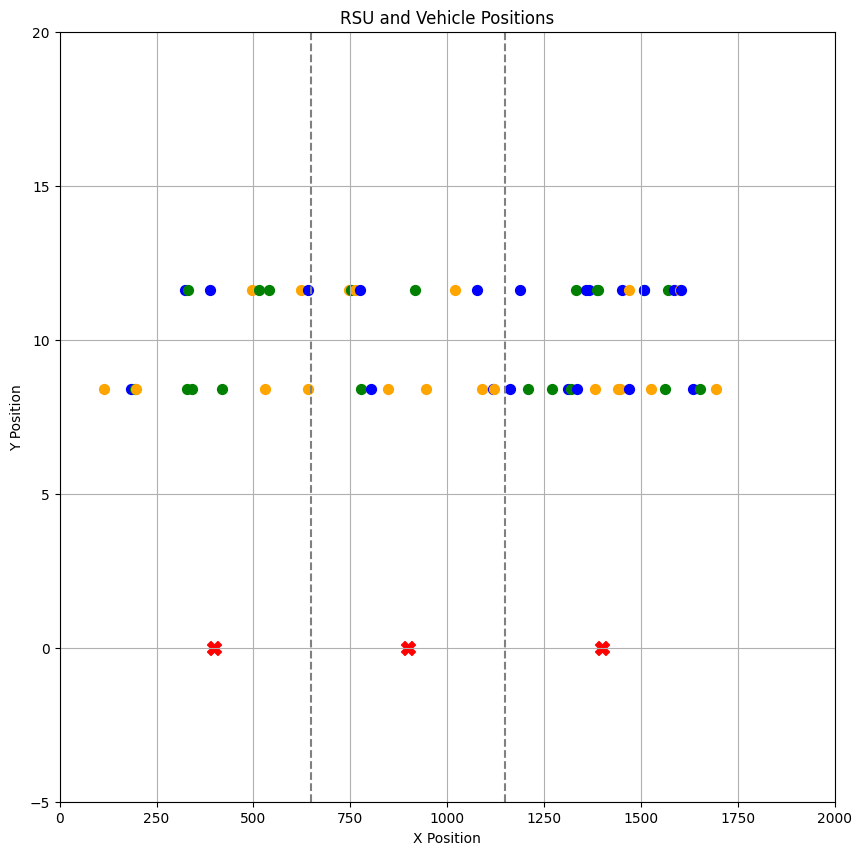

In [119]:
import numpy as np
import matplotlib.pyplot as plt
import gym
from gym import spaces
from stable_baselines3 import A2C, SAC
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import math
from stable_baselines3.common.logger import configure
import torch as th

def plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments=None):
    third_column = vehicle_positions[:, 2]
    first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)

    plt.figure(figsize=(10, 10))
    plt.xlim(0, 2000)
    plt.ylim(-5, 20)

    # RSUのプロット
    plt.scatter(rsu_positions[:, 0], rsu_positions[:, 1], c='red', label='RSU', s=100, marker='X')
    
    # RSU間の垂直二等分線をプロット
    for i in range(len(rsu_positions)-1):
        j = (i + 1)# 次のRSUのインデックス
        # 2つのRSU間の中点を計算
        mid_x = (rsu_positions[i, 0] + rsu_positions[j, 0]) / 2
        mid_y = (rsu_positions[i, 1] + rsu_positions[j, 1]) / 2
        
        # 元の線の傾きを計算
        dx = rsu_positions[j, 0] - rsu_positions[i, 0]
        dy = rsu_positions[j, 1] - rsu_positions[i, 1]
        
        if dy == 0:  # y座標が同じ場合（水平線）
            # 垂直二等分線は中点を通るy軸に平行な線
            plt.axvline(x=mid_x, color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)
        else:
            # 一般的な場合
            slope = -dx / dy  # 垂直二等分線の傾き
            intercept = mid_y - slope * mid_x  # y切片

            # プロット範囲でのx値を計算
            x_min, x_max = plt.xlim()
            y_min, y_max = plt.ylim()
            x_vals = np.linspace(x_min, x_max, 500)
            y_vals = slope * x_vals + intercept

            # プロット範囲内のみ描画
            valid_indices = (y_vals >= y_min) & (y_vals <= y_max)
            plt.plot(x_vals[valid_indices], y_vals[valid_indices], color='gray', linestyle='--', label='Perpendicular Bisector' if i == 0 and j == 1 else None)

    correct_assignments = 0

    # 車両のプロット（ダミーデータを除外）
    for idx, vehicle_pos in enumerate(vehicle_positions[:first_index]):
        # アクションに基づいた色設定
        if assignments[idx] is not None:
            color = ['blue', 'green', 'orange'][assignments[idx]]
            plt.scatter(vehicle_pos[0], vehicle_pos[1], c=color, label=f'Vehicle {idx + 1}', s=50)
        else:
            print('error')
        
        distances = np.array([np.linalg.norm(vehicle_pos[:2] - rsu) for rsu in rsu_positions])
        closest_rsu = np.argmin(distances)
        if assignments[idx] == closest_rsu:
            correct_assignments += 1

    
    print("accuracy: " + str(correct_assignments/first_index))


    plt.title('RSU and Vehicle Positions')
    plt.xlabel('X Position')
    plt.ylabel('Y Position')
    # plt.legend()
    plt.grid()
    plt.show()

    



max_vehicles_num = 75

env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=max_vehicles_num)
# 環境の初期化
obs = env.reset(valid_num=max_vehicles_num-15)

model_path = f"a2c_vehicle_assignment_512*3_linear10_v{str(max_vehicles_num)}_0.0_1.0_nosort_with_dummyu30_ts100000"
model = A2C.load(model_path)

# 車両の位置を取得
rsu_positions = env.rsu_positions
vehicle_positions = env.vehicle_positions

third_column = vehicle_positions[:, 2]
first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)
valid_vehicle_positions = vehicle_positions[:first_index]

# 学習したモデルを用いてアクションを取得
assignments = model.predict(obs)[0]  # 各車両のアクションを取得

print(assignments[:first_index], np.bincount(assignments[:first_index]))

# プロットを表示
plot_rsu_vehicle_positions(rsu_positions, vehicle_positions, assignments)


IMMUによる車両配分

In [2]:
import re
import json
import numpy as np
import gym
from gym import spaces
from stable_baselines3 import A2C
from stable_baselines3.common.callbacks import BaseCallback
import matplotlib.pyplot as plt
import copy

def immu_vehicle_assignment(communicable_validator_list, validator_geographic_list):
	rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]      # 第3のRSUの位置
    ])

	env_max_vehicle_num = -1
	print(len(communicable_validator_list))
	if len(communicable_validator_list) > 15 and len(communicable_validator_list) <= 45:
		env_max_vehicle_num = 45
	elif len(communicable_validator_list) > 45 and len(communicable_validator_list) <= 75:
		env_max_vehicle_num = 75
	elif len(communicable_validator_list) > 75 and len(communicable_validator_list) <= 105:
		env_max_vehicle_num = 105
	elif len(communicable_validator_list) > 105 and len(communicable_validator_list) <= 135:
		env_max_vehicle_num = 135
	else:
		print("error")
		env_max_vehicle_num = 45

	env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=env_max_vehicle_num)
	model_path = f"./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v{str(env_max_vehicle_num)}_0.6_0.4_nosort_with_dummyu30_ts100000"
	model = A2C.load(model_path)
	

	for index, _ in enumerate(validator_geographic_list):
		validator_geographic_list[index].append(0)

	while len(communicable_validator_list) < env_max_vehicle_num:
		# len(communicable_validator_list)がmax_vehicleになるまでrsu_positions[len(communicable_validator_list)%3]を追加
		communicable_validator_list.append("-1")
		validator_geographic_list.append([10000, 10000, 1])
	
    # `validator_geographic_list`に基づいて`communicable_validator_list`と`validator_geographic_list`を並び替える
	sorted_lists = sorted(zip(communicable_validator_list, validator_geographic_list), key=lambda x: (x[1][0], x[1][1]))
	communicable_validator_list = [v for v, _ in sorted_lists]
	validator_geographic_list = [x for _, x in sorted_lists]


	# ここで、各validatorに対して、最も近いproposerを割り当てる
	obs = env.set_initial_vehicle_positions(np.array(validator_geographic_list))
	assignments = model.predict(obs)[0]
	
	assignments_result_json = []
	assignments_result_json.append([])
	assignments_result_json.append([])
	assignments_result_json.append([])
	for index, validator_id in enumerate(communicable_validator_list):
		if validator_id != "-1":
			assignments_result_json[assignments[index]].append(int(validator_id))

	for assignment in assignments_result_json:
		assignment.sort()
		

	return assignments_result_json
		

# read the json file
max_speed = 70 # km/hour
min_speed = 30
proposer_list = [0,1,2]

vehicle_assignment_result_timeline = {}
for proposer_id in proposer_list:
	vehicle_assignment_result_timeline[proposer_id] = {}
geographic_time_json = {}

for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/" + str(proposer_id) + "/"
	# log_foloder_path下のextended_time_geographic_data.jsonを読み込む
	extended_time_geographic_data_path = log_folder_path + "extended_time_geographic_data.json"
	with open(extended_time_geographic_data_path) as f:
		extended_time_geographic_data = json.load(f)
	geographic_time_json[proposer_id] = extended_time_geographic_data

# geographic_time_jsonのそれぞれの中身で共通のkeyを取得
common_keys = set(geographic_time_json[proposer_list[0]].keys())
for proposer_id in proposer_list:
	common_keys = common_keys & set(geographic_time_json[proposer_id].keys())
# listに直してsort
common_keys = list(common_keys)
# 中身を数値に直してソートをした後、strに直す
# strに直すとき絶対に小数点第2位まで表示される文字列にする
common_keys = [str("{:.2f}".format(float(num))) for num in sorted([float(num) for num in common_keys])]

print(common_keys)

# common_keysの中身を使って、各validatorに対して、最も近いproposerを割り当てる

old_grapchic_data = {}
now_grapchic_data = {}
old_vehicle_assignment_result = {}

for proposer_id in proposer_list:
	old_vehicle_assignment_result[proposer_id] = {}

for time_key in common_keys:
	communicable_validator_list = []
	validator_geographic_list = []
	
	for proposer_id in proposer_list:
		now_grapchic_data[proposer_id] = geographic_time_json[proposer_id][time_key]
	
	if old_grapchic_data == now_grapchic_data:
		for proposer_id in proposer_list:
			vehicle_assignment_result_timeline[proposer_id][time_key] = old_vehicle_assignment_result[proposer_id]
		continue

	# validatorに対して、最も近いproposerを割り当てる
	temporary_json = {}
	for proposer_id in proposer_list:
		for validator_id_item, validator_geographic_item in geographic_time_json[proposer_id][time_key].items():
			temporary_json[validator_id_item] = [float(num) for num in re.findall(r"[-+]?\d*\.\d+|\d+", validator_geographic_item)][:2]
	#temporary_json のkeyをcommunicable_validator_listに、valueをvalidator_geographic_listに格納
	for key, value in temporary_json.items():
		communicable_validator_list.append(key)
		validator_geographic_list.append(value)
	
	# ここで、各validatorに対して、最も近いproposerを割り当てる
	assignments_result_item = immu_vehicle_assignment(communicable_validator_list, validator_geographic_list)
	for proposer_id in proposer_list:
		vehicle_assignment_result_timeline[proposer_id][time_key] = assignments_result_item[proposer_id]
		old_vehicle_assignment_result[proposer_id] = assignments_result_item[proposer_id]
		# print(vehicle_assignment_result_timeline[proposer_id][time_key])

	old_grapchic_data = copy.deepcopy(now_grapchic_data)

	print(time_key)


# immu_decided_participant_node_0or1or２.jsonに書き込む
for proposer_id in proposer_list:
	log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/" + str(proposer_id) + "/"
	with open(log_folder_path + "immu_wd_decided_participant_node_" + str(proposer_id) + ".json", "w") as f:
		json.dump(vehicle_assignment_result_timeline[proposer_id], f, indent=4)


['1.02', '1.03', '1.04', '1.05', '1.06', '1.07', '1.08', '1.09', '1.10', '1.11', '1.12', '1.13', '1.14', '1.15', '1.16', '1.17', '1.18', '1.19', '1.20', '1.21', '1.22', '1.23', '1.24', '1.25', '1.26', '1.27', '1.28', '1.29', '1.30', '1.31', '1.32', '1.33', '1.34', '1.35', '1.36', '1.37', '1.38', '1.39', '1.40', '1.41', '1.42', '1.43', '1.44', '1.45', '1.46', '1.47', '1.48', '1.49', '1.50', '1.51', '1.52', '1.53', '1.54', '1.55', '1.56', '1.57', '1.58', '1.59', '1.60', '1.61', '1.62', '1.63', '1.64', '1.65', '1.66', '1.67', '1.68', '1.69', '1.70', '1.71', '1.72', '1.73', '1.74', '1.75', '1.76', '1.77', '1.78', '1.79', '1.80', '1.81', '1.82', '1.83', '1.84', '1.85', '1.86', '1.87', '1.88', '1.89', '1.90', '1.91', '1.92', '1.93', '1.94', '1.95', '1.96', '1.97', '1.98', '1.99', '2.00', '2.01', '2.02', '2.03', '2.04', '2.05', '2.06', '2.07', '2.08', '2.09', '2.10', '2.11', '2.12', '2.13', '2.14', '2.15', '2.16', '2.17', '2.18', '2.19', '2.20', '2.21', '2.22', '2.23', '2.24', '2.25', '2.26',

/home/lucvil/.pyenv/versions/3.11.4/lib/python3.11/site-packages/torch/cuda/__init__.py:129: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at ../c10/cuda/CUDAFunctions.cpp:108.)
  return torch._C._cuda_getDeviceCount() > 0


1.02
1
error
13.01
2
error
13.02
2
error
14.03
2
error
14.04
2
error
15.05
2
error
15.06
3
error
16.01
4
error
16.02
4
error
17.03
4
error
17.04
4
error
18.05
4
error
18.06
4
error
19.01
5
error
19.02
6
error
20.03
6
error
20.04
6
error
21.05
6
error
21.06
6
error
22.01
6
error
22.02
6
error
23.03
6
error
23.04
6
error
24.05
6
error
24.06
7
error
25.01
8
error
25.02
8
error
26.03
8
error
26.04
8
error
27.05
8
error
27.06
8
error
28.01
8
error
28.02
8
error
29.03
8
error
29.04
9
error
30.05
10
error
30.06
10
error
31.01
10
error
31.02
10
error
32.03
10
error
32.04
10
error
33.05
10
error
33.06
10
error
34.01
11
error
34.02
12
error
35.03
12
error
35.04
12
error
36.05
12
error
36.06
12
error
37.01
12
error
37.02
12
error
38.03
12
error
38.04
12
error
39.05
12
error
39.06
13
error
40.01
14
error
40.02
14
error
41.03
14
error
41.04
14
error
42.05
14
error
42.06
14
error
43.01
14
error
43.02
14
error
44.03
15
error
44.04
16
45.05
16
45.06
16
46.01
16
46.02
16
47.03
16
47.04
16
48.05
16
48.0

参加者の分布表示

[0, 0, 0, 0, 2, 4, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 6, 6, 6, 7, 6, 8, 8, 8, 9, 9, 9, 9, 10, 10, 11, 12, 11, 13, 13, 13, 13, 14, 15, 14, 16, 15, 16, 17, 16, 17, 17, 19, 18, 18, 19, 19, 21, 21, 20, 22, 21, 23, 25, 23, 24, 26, 25, 24, 22, 26, 26, 26, 26, 27, 27, 27, 26, 28, 29, 30, 28, 26, 29, 26, 26, 26, 25, 26, 24, 23, 21, 21, 19, 20, 17, 18, 17, 16, 16, 15, 15, 13, 12, 12, 13, 13, 14, 15, 15, 16, 17, 15, 16, 16, 16, 17, 18, 18, 18, 19, 19, 20, 21, 21, 21, 23, 24, 23, 24, 25, 24, 24, 23, 24, 27, 26, 26, 26, 27, 27, 26, 29, 28, 28, 29, 28, 29, 26, 28, 26, 27, 23, 26, 25, 23, 20, 22, 21, 21, 19, 17, 17, 16, 13, 14, 14, 12, 13, 12, 12, 13, 15, 14, 15, 15, 14, 15, 16, 16, 16, 17, 18, 18, 18, 18, 18, 18, 20, 20, 20, 20, 21, 21, 22, 24, 24, 23, 25, 24, 24, 25, 25, 25, 27, 27, 27, 26, 27, 29, 29, 28, 28, 30, 28, 27, 26, 25, 23, 23, 20, 19, 20, 17, 17, 16, 14, 13, 11, 11, 9, 8, 6, 6, 5, 6, 6, 6, 6, 5, 5, 4, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 5, 5, 6, 6, 5, 5, 5, 5, 5, 6, 5, 5, 5, 5, 5, 5, 4, 6, 5, 4

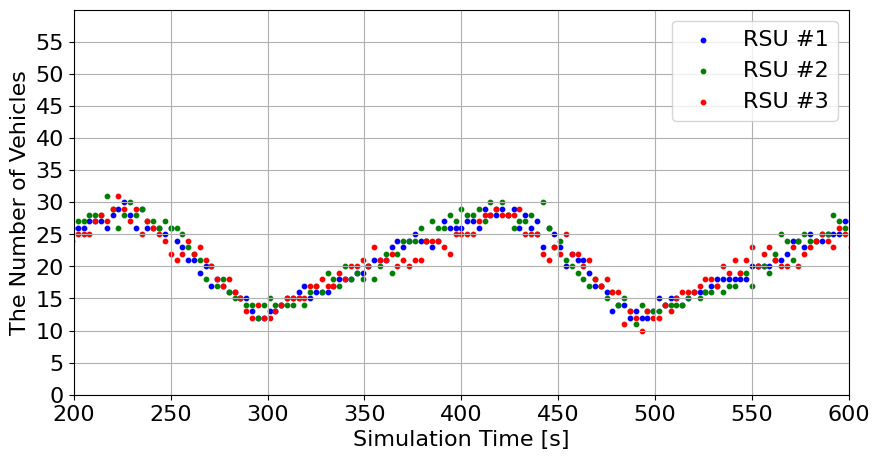

In [4]:
import matplotlib.pyplot as plt
import json

def count_nodes_for_plot_in_multiple_scenario(proposer_id, log_folder_path):

    extracted_events_file_path = log_folder_path + str(proposer_id) + "/immu_wd_decided_participant_node_" + str(proposer_id) + ".json"

    # extracted_events.json jsonデータを読み込む
    with open(extracted_events_file_path, 'r') as f:
        data = json.load(f)


    # グラフにプロットするデータを抽出
    time_series = []
    status_counts = []

    for time_key, participant_node_list in data.items():
        # print(participant_node_list)
        start_time = float(time_key)
        status_count = len(participant_node_list)
        time_series.append(start_time)
        status_counts.append(status_count)

    
    return time_series, status_counts

max_speed = 70
min_speed = 30
proposer_list = [0,1,2]
validator_num = 250
log_folder_path = "./results/speed" + str(max_speed) + "_" + str(min_speed) + "/250vehicle/"


# proposer_id 0
time_series, status_counts = count_nodes_for_plot_in_multiple_scenario(proposer_list[0], log_folder_path)

# proposer_id 1
time_series2, status_counts2 = count_nodes_for_plot_in_multiple_scenario(proposer_list[1], log_folder_path)

# proposer_id 2
time_series3, status_counts3 = count_nodes_for_plot_in_multiple_scenario(proposer_list[2], log_folder_path)

#time_series, status_countsたちを10個おきにする
time_series = time_series[::300]
status_counts = status_counts[::300]
time_series2 = time_series2[::300]
status_counts2 = status_counts2[::300]
time_series3 = time_series3[::300]
status_counts3 = status_counts3[::300]

print(status_counts)

# 3つwo1つのgraphにまとめる
plt.figure(figsize=(10, 5))
# plt.scatter(time_series, status_counts, facecolors='none', edgecolors='blue', marker='o', s=10, label='RSU No.1')
# plt.scatter(time_series2, status_counts2, facecolors='none', edgecolors='green', marker='o', s=10, label='RSU No.2')
# plt.scatter(time_series3, status_counts3, facecolors='none', edgecolors='red', marker='o', s=10, label='RSU No.3')
plt.scatter(time_series, status_counts, c='blue', marker='o', s=10, label='RSU #1')
plt.scatter(time_series2, status_counts2, c='green', marker='o', s=10, label='RSU #2')
plt.scatter(time_series3, status_counts3, c='red', marker='o', s=10, label='RSU #3')
plt.xlabel('Simulation Time [s]', fontsize=16)
plt.ylabel('The Number of Vehicles', fontsize=16)

# plt.ylim(0, None)
# plt.xlim(0, 800)
plt.ylim(0, 60)
plt.xlim(200, 600)

plt.xticks(fontsize=16)
plt.yticks(range(0, 60, 5),fontsize=16)

plt.grid(True)
plt.legend(fontsize=16)
plt.show()

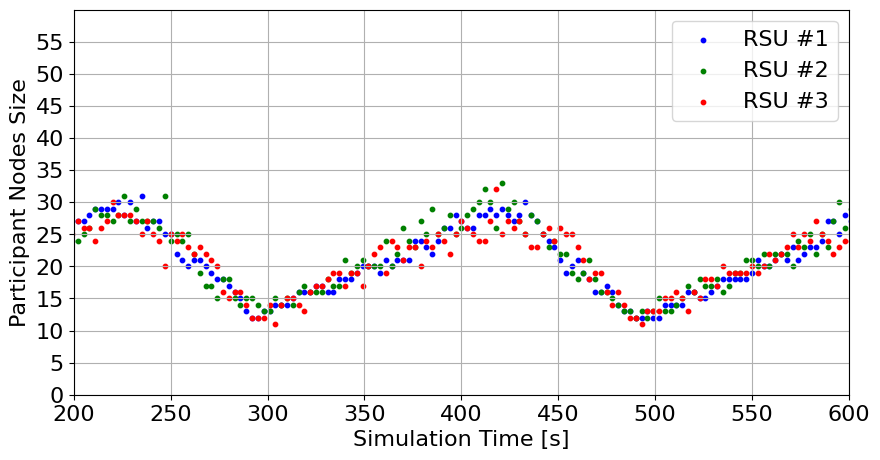

学習の評価の重み付けを変えたときの比較実験

./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_0.0_1.0_nosort_with_dummyu30_ts100000
./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_0.2_0.8_nosort_with_dummyu30_ts100000
./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_0.4_0.6_nosort_with_dummyu30_ts100000
./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_0.6_0.4_nosort_with_dummyu30_ts100000
error
./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_0.8_0.2_nosort_with_dummyu30_ts100000
error
./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v75_1.0_0.0_nosort_with_dummyu30_ts100000


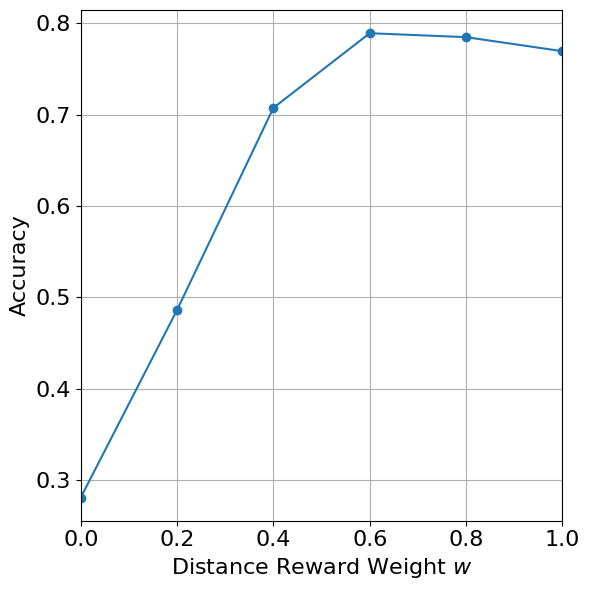

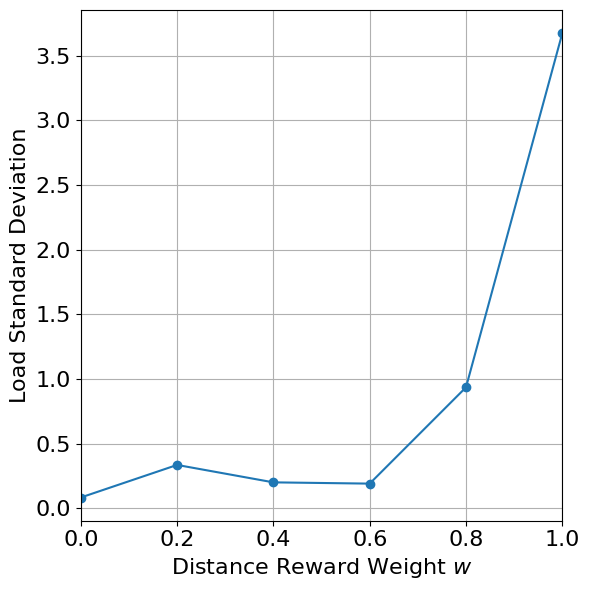

In [6]:
from stable_baselines3 import A2C
from statistics import mean

def caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, valid_vehicle_num):

    correct_assignments_sum = 0
    assignments_exteneded_list = []
    for i in range(int(sim_max_vehicles / env_max_vehicles)):
        # 環境の初期化
        obs = env.set_initial_vehicle_positions_random(valid_vehicle_num)

        third_column = env.vehicle_positions[:, 2]
        first_index = np.where(third_column == 1)[0][0] if np.any(third_column == 1) else len(third_column)

        # 学習したモデルを用いてアクションを取得
        assignments = model.predict(obs)[0]

        # RSUの位置
        rsu_positions = np.array([
            [398.4, 0],              # 第1のRSUの位置
            [898.4, 0],              # 第2のRSUの位置
            [1398.4, 0]              # 第3のRSUの位置
        ])

        # 正解率と標準偏差の計算
        correct_assignments = 0

        for idx, action in enumerate(assignments[:first_index]):
            vehicle_position = env.vehicle_positions[idx]
            distances = np.array([np.linalg.norm(vehicle_position[:2] - rsu) for rsu in rsu_positions])
            closest_rsu = np.argmin(distances)
            if action == closest_rsu:
                correct_assignments += 1


        correct_assignments_sum += correct_assignments

        # RSUごとの負荷を計算
        assignments_exteneded_list.extend(assignments[:first_index])

    accuracy = correct_assignments_sum / (first_index)
    rsu_loads = np.bincount(assignments_exteneded_list, minlength=env.num_rsus)
    load_std_dev = np.std(rsu_loads)
    return accuracy, load_std_dev

def caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations, valid_vehicle_num):
    accuracy_list = []
    load_std_dev_list = []

    for i in range(num_evaluations):
        accuracy_item, load_std_dev_item = caluculate_single_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, valid_vehicle_num)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
    
    accuracy_average = mean(accuracy_list)
    load_std_dev_average = mean(load_std_dev_list)

    return accuracy_average, load_std_dev_average


# weight_list を用いてモデルをロードし、評価する
weight_list = [0, 0.2, 0.4, 0.6, 0.7, 0.8, 0.9, 1.0]
# vehicle_num_list = [30, 60, 90]
vehicle_num_list = [60]
num_evaluations = 500
accuracy_2list = []
load_std_dev_2list = []
real_weight_list = []
for vehicle_num in vehicle_num_list:
    env_max_vehicles = vehicle_num + 15
    sim_max_vehicles = vehicle_num + 15

    # 環境の作成
    env = VehicleAssignmentEnv(num_rsus=3, max_vehicles=env_max_vehicles)

    accuracy_list = []
    load_std_dev_list = []
    for weight in weight_list:
        weight_1 = weight
        weight_2 = 1.0 - weight
        model_path = f"./models/512*3_first_random_with_min20_with_dummyu30_ts100000/a2c_vehicle_assignment_512*3_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}_nosort_with_dummyu30_ts100000"
        # model_path = f"./models/512*3_first_random_with_min20_ts50000/a2c_vehicle_assignment_512*3_linear10_v{env_max_vehicles}_{weight_1:.1f}_{weight_2:.1f}_first_random_with_min20_ts50000"
        try:
            model = A2C.load(model_path)
        except:
            print("error")
            continue


        accuracy_item, load_std_dev_item = caluculate_multi_spec_rl(env, model, env_max_vehicles, sim_max_vehicles, num_evaluations, vehicle_num)
        accuracy_list.append(accuracy_item)
        load_std_dev_list.append(load_std_dev_item)
        if len(accuracy_2list) ==0 :
            real_weight_list.append(weight)
        print(model_path)
    accuracy_2list.append(accuracy_list)
    load_std_dev_2list.append(load_std_dev_list)

# グラフのプロット
plt.figure(figsize=(6, 6))

# (a) Accuracy
# plt.subplot(1, 2, 1)
for i, vehicle_num in enumerate(vehicle_num_list):
    plt.plot(real_weight_list, accuracy_2list[i], marker='o', linestyle='-', label=f'Vehicle Num {vehicle_num}')
plt.xlabel("Distance Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel("Accuracy", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
# plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# (b) Load Standard Deviation
# plt.subplot(1, 2, 2)
plt.figure(figsize=(6, 6))
for i, vehicle_num in enumerate(vehicle_num_list):
    plt.plot(real_weight_list, load_std_dev_2list[i], marker='o', linestyle='-', label=f'Vehicle Num {vehicle_num}')
plt.xlabel("Distance Reward Weight " + r"$\mathit{w}$", fontsize=16)
plt.ylabel("Load Standard Deviation", fontsize=16)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)
plt.xlim(0, 1.0)
# plt.legend(fontsize=12)
plt.grid(True)

plt.tight_layout()
plt.show()

# # 図の下部にラベルを配置
# plt.subplots_adjust(bottom=0.2)  # 下部スペース確保
# plt.figtext(0.15, -0.02, "(a) Performance Accuracy", fontsize=16)
# plt.figtext(0.58, -0.02, "(b) Performance Load Standard Deviation", fontsize=16)






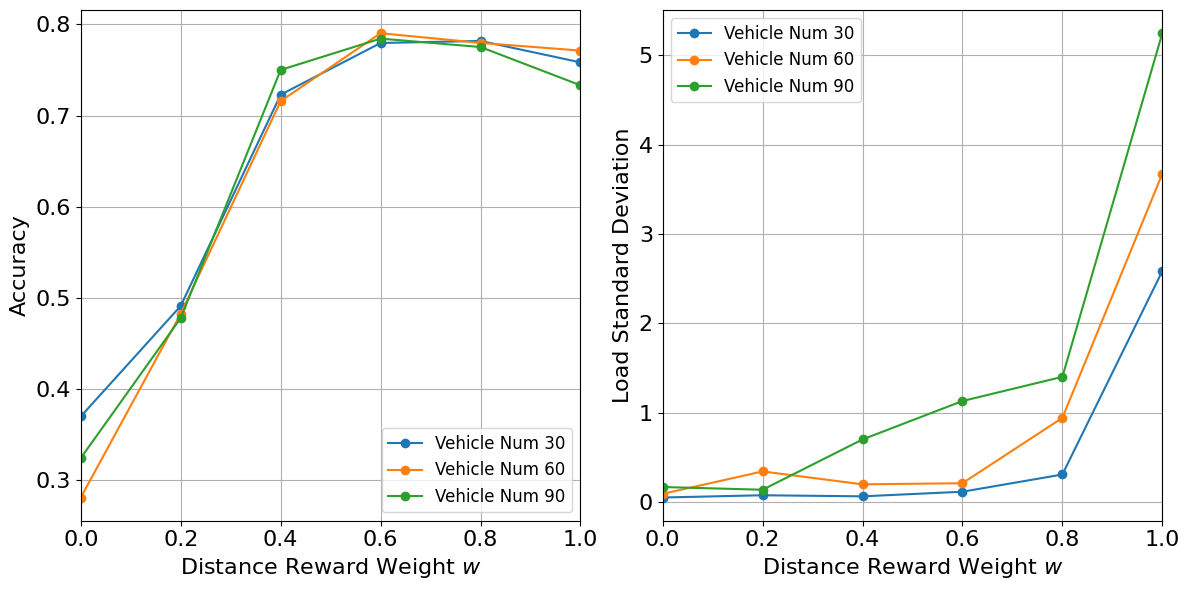